# All the Imports

In [1]:
import sys
import os
import logging
sys.path.insert(1, '../src/')

In [2]:
%%time 
import itertools 
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from lassonet import LassoNetClassifier



from RankCorr.picturedRocks import Rocks
import smashpy as smashpy


import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

from utils import *


CPU times: user 7.81 s, sys: 629 ms, total: 8.44 s
Wall time: 7.85 s


In [3]:
logging.getLogger("numpy").setLevel(logging.ERROR)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

logging.getLogger("lightning").setLevel(logging.ERROR)
pl_loggers = [ logging.getLogger(name) for name in logging.root.manager.loggerDict if 'lightning' in name ]

for logger in pl_loggers:
    logger.setLevel(logging.ERROR)

# These should be parameters later on 

In [4]:
z_size = 16
hidden_layer_size = 256

# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
batch_size = 64
batch_norm = True


global_t = 3.0

k_range = [10, 50, 100, 250]
k = 50
num_times = 10

gpus = 1
tpu_cores = None
precision=32

In [5]:
import multiprocessing

num_cores = multiprocessing.cpu_count()

# Here goes all the stuff that we change from dataset to dataset

In [6]:
from os import path

In [7]:
dataset_dir = '../data/paul/'
model_save_path = '../data/paul/models/'
viz_save_path = '../data/paul/visualizations/'

if not path.exists(model_save_path):
  os.makedirs(model_save_path)

if not path.exists(model_save_path + 'experiment_data_folds/'):
  os.makedirs(model_save_path + 'experiment_data_folds/')
  
if not path.exists(viz_save_path):
  os.makedirs(viz_save_path)

  

# Dataset Specific Processing

`

In [8]:
adata = sc.datasets.paul15()

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'paul15_clusters' as categorical
Trying to set attribute `._uns` of view, copying.


In [9]:
sm = smashpy.smashpy()
housekeeping_gene_direct = '../data/housekeeping_genes/'
sm.data_preparation(adata)
adata = sm.remove_general_genes(adata)
adata = sm.remove_housekeepingenes(adata, path=[housekeeping_gene_direct + "house_keeping_genes_Mouse_bone_marrow.txt"])
adata = sm.remove_housekeepingenes(adata, path=[housekeeping_gene_direct + "house_keeping_genes_Mouse_HSC.txt"])

 * Initialising ...



In [10]:
dict_annotation = {}

dict_annotation['1Ery']='Ery'
dict_annotation['2Ery']='Ery'
dict_annotation['3Ery']='Ery'
dict_annotation['4Ery']='Ery'
dict_annotation['5Ery']='Ery'
dict_annotation['6Ery']='Ery'
dict_annotation['7MEP']='MEP'
dict_annotation['8Mk']='Mk'
dict_annotation['9GMP']='GMP'
dict_annotation['10GMP']='GMP'
dict_annotation['11DC']='DC'
dict_annotation['12Baso']='Baso'
dict_annotation['13Baso']='Baso'
dict_annotation['14Mo']='Mo'
dict_annotation['15Mo']='Mo'
dict_annotation['16Neu']='Neu'
dict_annotation['17Neu']='Neu'
dict_annotation['18Eos']='Eos'
dict_annotation['19Lymph']='Lymph'

annotation = []
for celltype in adata.obs["paul15_clusters"].tolist():
    annotation.append(dict_annotation[celltype])

adata.obs['annotation'] = annotation
adata.obs['annotation'] = adata.obs['annotation'].astype("category")

In [11]:
adata.obs

paul15_clusters  n_counts annotation
0               7MEP     353.0        MEP
1               15Mo    2556.0         Mo
2               3Ery    4649.0        Ery
3               15Mo    4486.0         Mo
4               3Ery    5205.0        Ery
...              ...       ...        ...
2725            2Ery    4873.0        Ery
2726          13Baso    3553.0       Baso
2727            7MEP     443.0        MEP
2728            15Mo    3252.0         Mo
2729            3Ery    6401.0        Ery

[2730 rows x 3 columns]

In [12]:
X = adata.X.copy()

labels = adata.obs['annotation'].values
encoder = LabelEncoder()
encoder.fit(labels)
y = encoder.transform(labels)

In [13]:
input_size = X.shape[1]

In [14]:
X.shape

(2730, 3113)

# Set Up Models

### Baseline

In [15]:
%%time
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    all_markers = np.arange(X.shape[1])
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = all_markers)
    np.save(model_save_path + 'all_markers_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'all_markers_{}.npy'.format(tryy), all_markers)
    np.save(model_save_path + 'experiment_data_folds/all_markers_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'All Marker Visualization', path = viz_save_path + 'all_markers_{}.pdf'.format(tryy), markers = all_markers)

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted s

CPU times: user 4min 1s, sys: 3.63 s, total: 4min 4s
Wall time: 2min 30s


## Train Smash Random Forest





In [16]:
# needed for random forest Smash
!mkdir Figures

mkdir: cannot create directory ‘Figures’: File exists


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

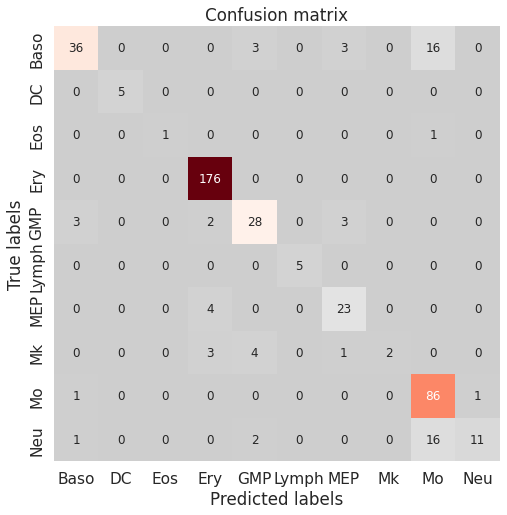

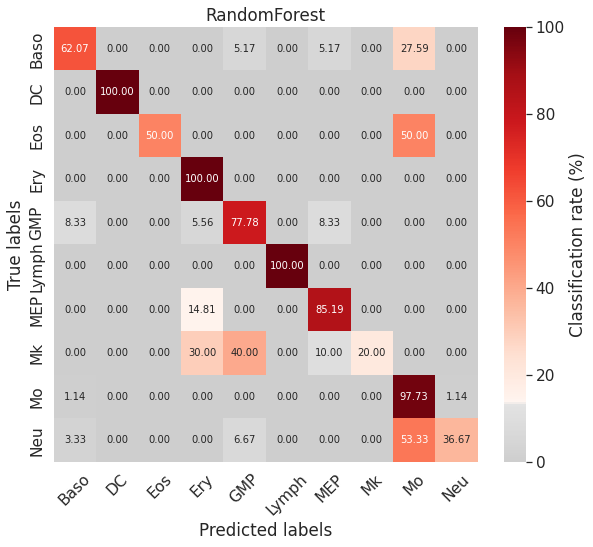

Accuracy: 0.8535469107551488: Misclassification: 0.14645308924485123
              precision    recall  f1-score   support

        Baso       0.88      0.62      0.73        58
          DC       1.00      1.00      1.00         5
         Eos       1.00      0.50      0.67         2
         Ery       0.95      1.00      0.98       176
         GMP       0.76      0.78      0.77        36
       Lymph       1.00      1.00      1.00         5
         MEP       0.77      0.85      0.81        27
          Mk       1.00      0.20      0.33        10
          Mo       0.72      0.98      0.83        88
         Neu       0.92      0.37      0.52        30

    accuracy                           0.85       437
   macro avg       0.90      0.73      0.76       437
weighted avg       0.87      0.85      0.84       437



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

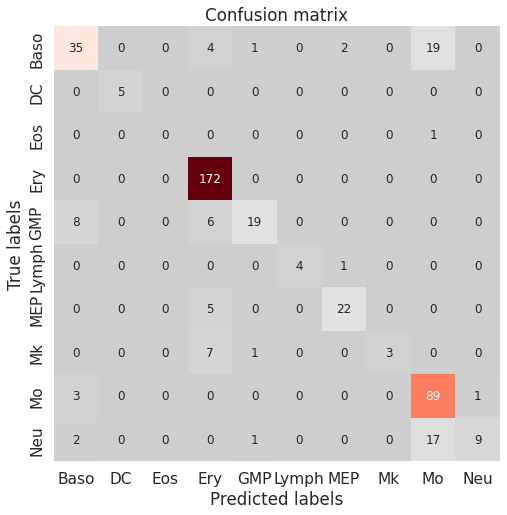

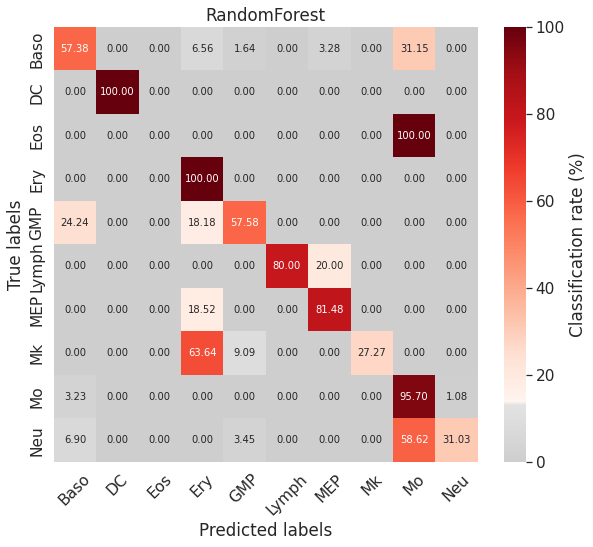

Accuracy: 0.8192219679633868: Misclassification: 0.18077803203661325
              precision    recall  f1-score   support

        Baso       0.73      0.57      0.64        61
          DC       1.00      1.00      1.00         5
         Eos       0.00      0.00      0.00         1
         Ery       0.89      1.00      0.94       172
         GMP       0.86      0.58      0.69        33
       Lymph       1.00      0.80      0.89         5
         MEP       0.88      0.81      0.85        27
          Mk       1.00      0.27      0.43        11
          Mo       0.71      0.96      0.81        93
         Neu       0.90      0.31      0.46        29

    accuracy                           0.82       437
   macro avg       0.80      0.63      0.67       437
weighted avg       0.83      0.82      0.80       437



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

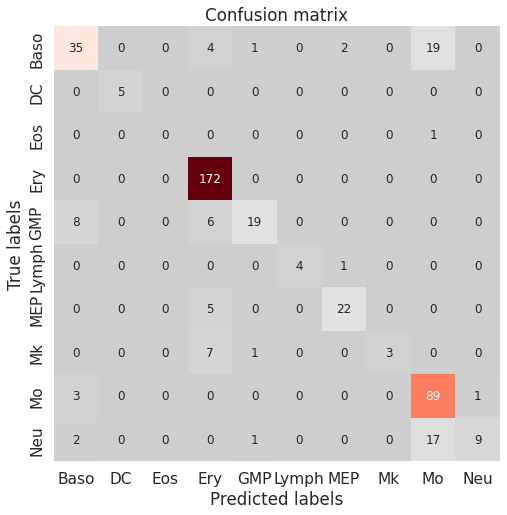

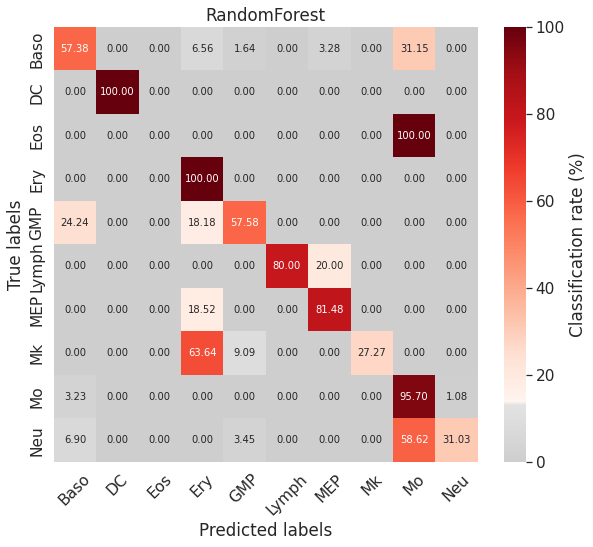

Accuracy: 0.8192219679633868: Misclassification: 0.18077803203661325
              precision    recall  f1-score   support

        Baso       0.73      0.57      0.64        61
          DC       1.00      1.00      1.00         5
         Eos       0.00      0.00      0.00         1
         Ery       0.89      1.00      0.94       172
         GMP       0.86      0.58      0.69        33
       Lymph       1.00      0.80      0.89         5
         MEP       0.88      0.81      0.85        27
          Mk       1.00      0.27      0.43        11
          Mo       0.71      0.96      0.81        93
         Neu       0.90      0.31      0.46        29

    accuracy                           0.82       437
   macro avg       0.80      0.63      0.67       437
weighted avg       0.83      0.82      0.80       437



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

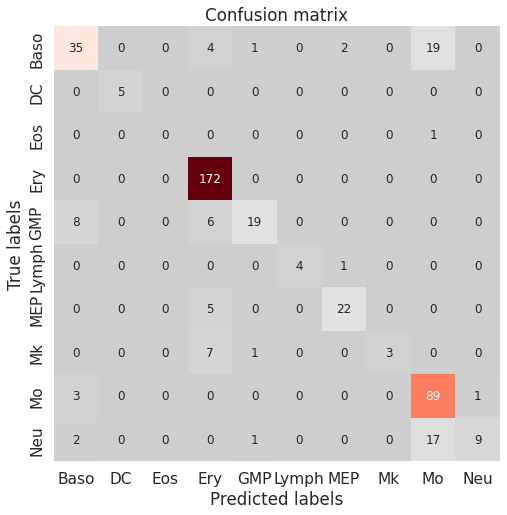

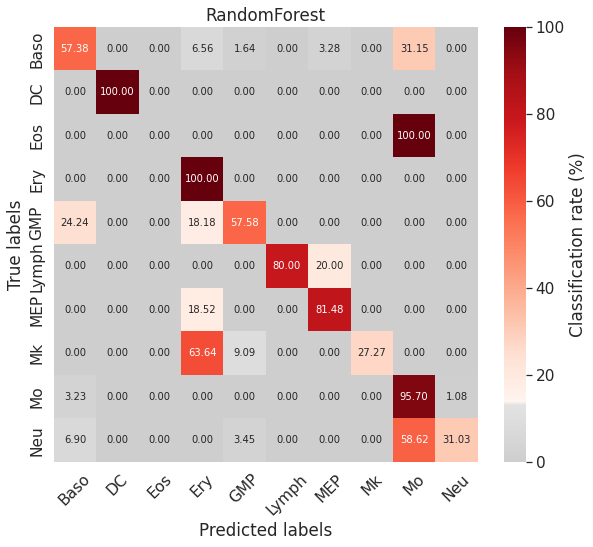

Accuracy: 0.8192219679633868: Misclassification: 0.18077803203661325
              precision    recall  f1-score   support

        Baso       0.73      0.57      0.64        61
          DC       1.00      1.00      1.00         5
         Eos       0.00      0.00      0.00         1
         Ery       0.89      1.00      0.94       172
         GMP       0.86      0.58      0.69        33
       Lymph       1.00      0.80      0.89         5
         MEP       0.88      0.81      0.85        27
          Mk       1.00      0.27      0.43        11
          Mo       0.71      0.96      0.81        93
         Neu       0.90      0.31      0.46        29

    accuracy                           0.82       437
   macro avg       0.80      0.63      0.67       437
weighted avg       0.83      0.82      0.80       437



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

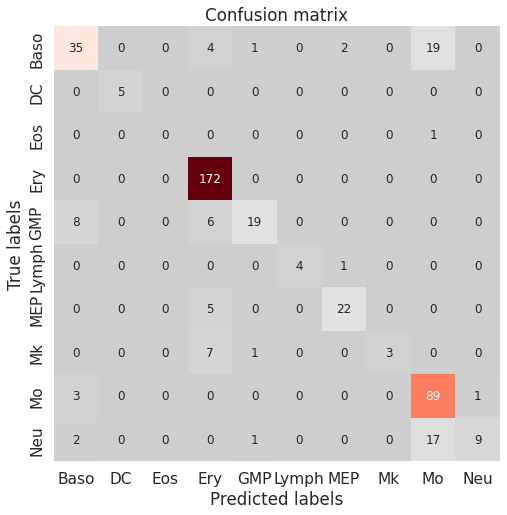

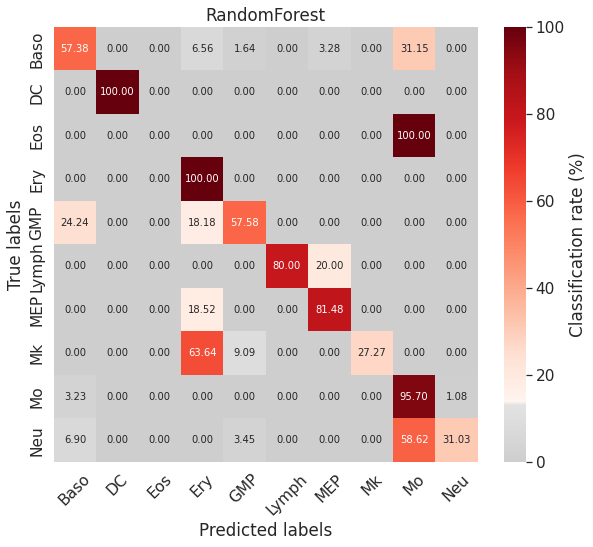

Accuracy: 0.8192219679633868: Misclassification: 0.18077803203661325
              precision    recall  f1-score   support

        Baso       0.73      0.57      0.64        61
          DC       1.00      1.00      1.00         5
         Eos       0.00      0.00      0.00         1
         Ery       0.89      1.00      0.94       172
         GMP       0.86      0.58      0.69        33
       Lymph       1.00      0.80      0.89         5
         MEP       0.88      0.81      0.85        27
          Mk       1.00      0.27      0.43        11
          Mo       0.71      0.96      0.81        93
         Neu       0.90      0.31      0.46        29

    accuracy                           0.82       437
   macro avg       0.80      0.63      0.67       437
weighted avg       0.83      0.82      0.80       437



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

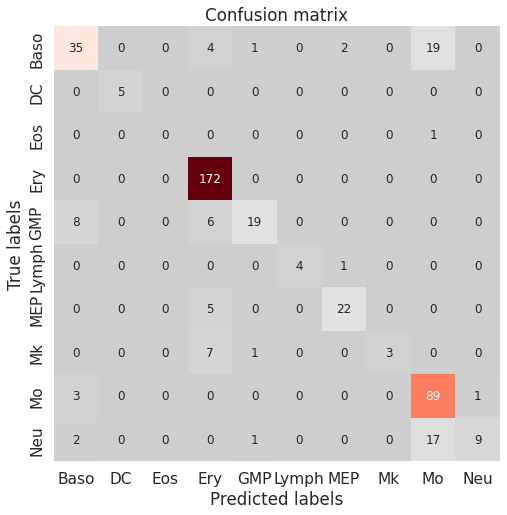

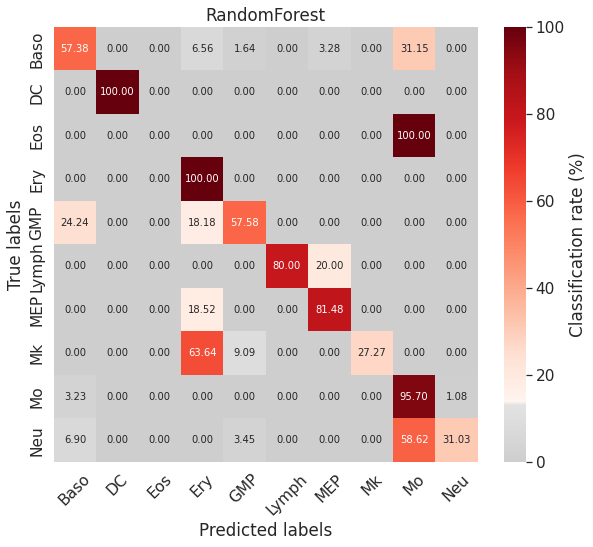

Accuracy: 0.8192219679633868: Misclassification: 0.18077803203661325
              precision    recall  f1-score   support

        Baso       0.73      0.57      0.64        61
          DC       1.00      1.00      1.00         5
         Eos       0.00      0.00      0.00         1
         Ery       0.89      1.00      0.94       172
         GMP       0.86      0.58      0.69        33
       Lymph       1.00      0.80      0.89         5
         MEP       0.88      0.81      0.85        27
          Mk       1.00      0.27      0.43        11
          Mo       0.71      0.96      0.81        93
         Neu       0.90      0.31      0.46        29

    accuracy                           0.82       437
   macro avg       0.80      0.63      0.67       437
weighted avg       0.83      0.82      0.80       437



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

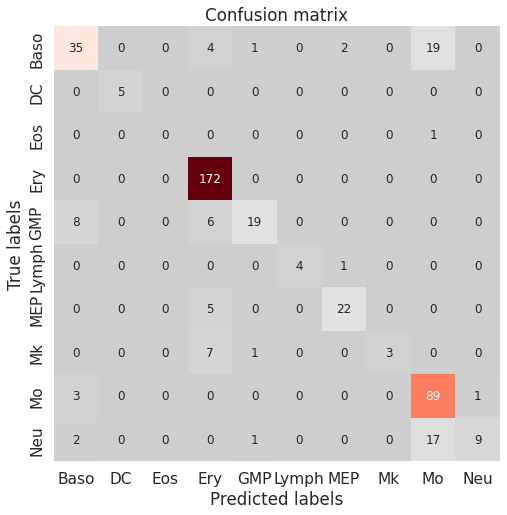

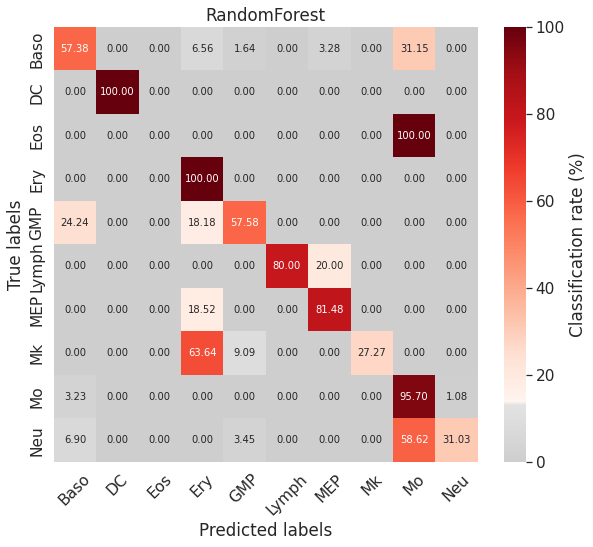

Accuracy: 0.8192219679633868: Misclassification: 0.18077803203661325
              precision    recall  f1-score   support

        Baso       0.73      0.57      0.64        61
          DC       1.00      1.00      1.00         5
         Eos       0.00      0.00      0.00         1
         Ery       0.89      1.00      0.94       172
         GMP       0.86      0.58      0.69        33
       Lymph       1.00      0.80      0.89         5
         MEP       0.88      0.81      0.85        27
          Mk       1.00      0.27      0.43        11
          Mo       0.71      0.96      0.81        93
         Neu       0.90      0.31      0.46        29

    accuracy                           0.82       437
   macro avg       0.80      0.63      0.67       437
weighted avg       0.83      0.82      0.80       437



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

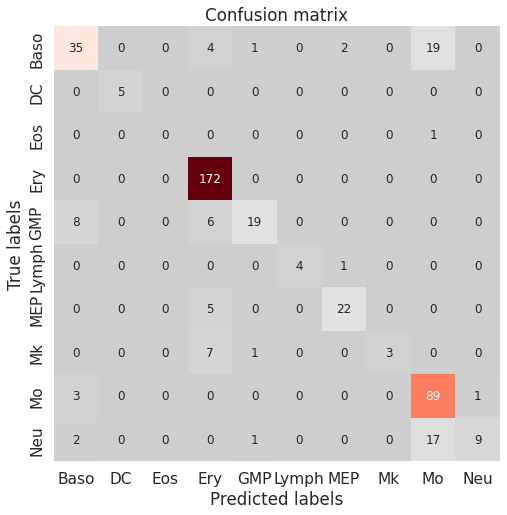

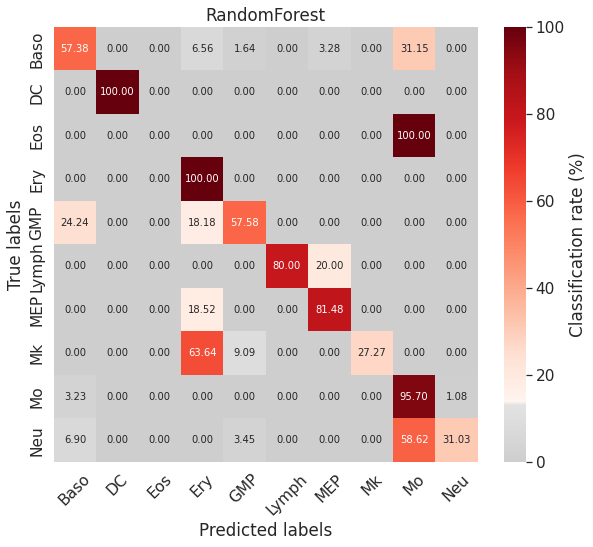

Accuracy: 0.8192219679633868: Misclassification: 0.18077803203661325
              precision    recall  f1-score   support

        Baso       0.73      0.57      0.64        61
          DC       1.00      1.00      1.00         5
         Eos       0.00      0.00      0.00         1
         Ery       0.89      1.00      0.94       172
         GMP       0.86      0.58      0.69        33
       Lymph       1.00      0.80      0.89         5
         MEP       0.88      0.81      0.85        27
          Mk       1.00      0.27      0.43        11
          Mo       0.71      0.96      0.81        93
         Neu       0.90      0.31      0.46        29

    accuracy                           0.82       437
   macro avg       0.80      0.63      0.67       437
weighted avg       0.83      0.82      0.80       437



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

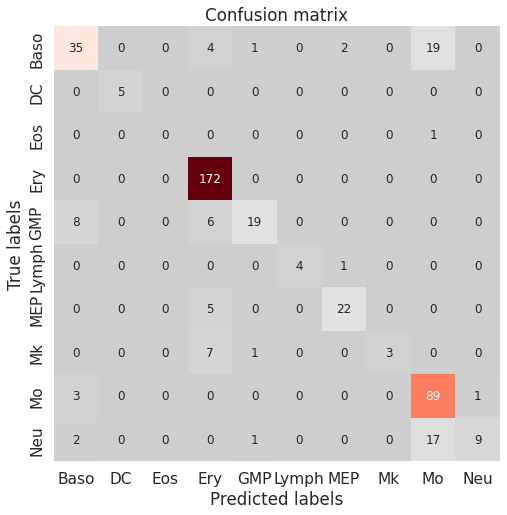

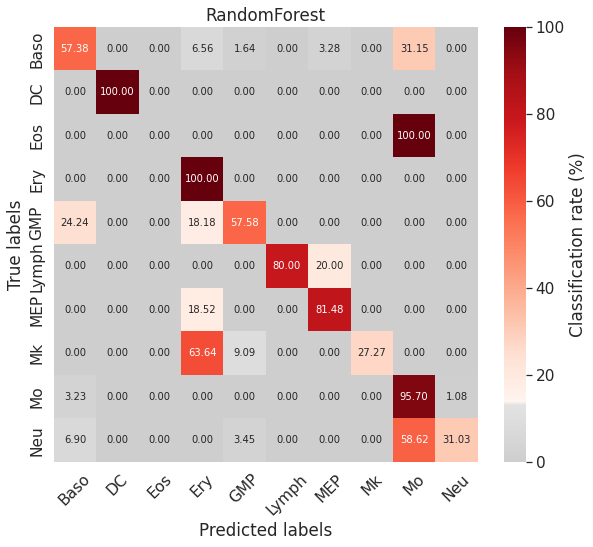

Accuracy: 0.8192219679633868: Misclassification: 0.18077803203661325
              precision    recall  f1-score   support

        Baso       0.73      0.57      0.64        61
          DC       1.00      1.00      1.00         5
         Eos       0.00      0.00      0.00         1
         Ery       0.89      1.00      0.94       172
         GMP       0.86      0.58      0.69        33
       Lymph       1.00      0.80      0.89         5
         MEP       0.88      0.81      0.85        27
          Mk       1.00      0.27      0.43        11
          Mo       0.71      0.96      0.81        93
         Neu       0.90      0.31      0.46        29

    accuracy                           0.82       437
   macro avg       0.80      0.63      0.67       437
weighted avg       0.83      0.82      0.80       437



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

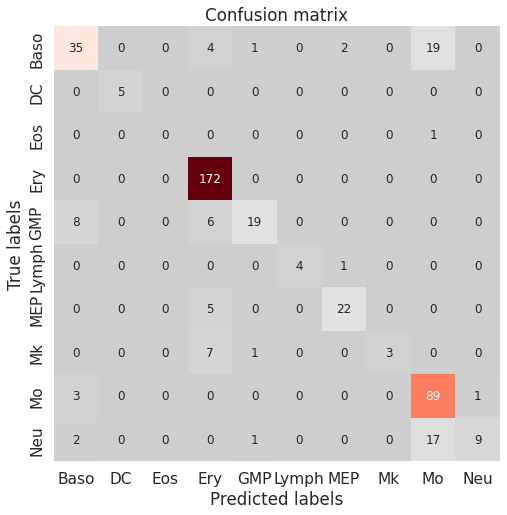

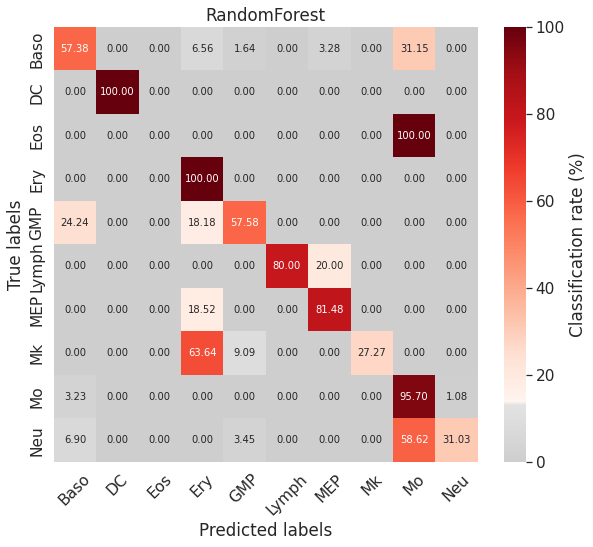

Accuracy: 0.8192219679633868: Misclassification: 0.18077803203661325
              precision    recall  f1-score   support

        Baso       0.73      0.57      0.64        61
          DC       1.00      1.00      1.00         5
         Eos       0.00      0.00      0.00         1
         Ery       0.89      1.00      0.94       172
         GMP       0.86      0.58      0.69        33
       Lymph       1.00      0.80      0.89         5
         MEP       0.88      0.81      0.85        27
          Mk       1.00      0.27      0.43        11
          Mo       0.71      0.96      0.81        93
         Neu       0.90      0.31      0.46        29

    accuracy                           0.82       437
   macro avg       0.80      0.63      0.67       437
weighted avg       0.83      0.82      0.80       437



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


CPU times: user 3min 25s, sys: 6.05 s, total: 3min 31s
Wall time: 2min 2s


In [17]:
%%time
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    train_X_y = adata[np.concatenate([train_indices, val_indices]), :]
    sm = smashpy.smashpy()
    clf = sm.ensemble_learning(train_X_y, group_by="annotation", classifier="RandomForest", balance=True, verbose=True)
    selectedGenes, selectedGenes_dict = sm.gini_importance(train_X_y, clf, group_by="annotation", verbose=True, restrict_top=("global", k))
    # since this selects k per class, need select randomly from each classes
    smash_markers = adata.var.index.get_indexer(selectedGenes)

    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = smash_markers)
    np.save(model_save_path + 'smash_rf_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'smash_rf_markers_{}.npy'.format(tryy), smash_markers)
    np.save(model_save_path + 'experiment_data_folds/smash_rf_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Smash Random Forest Marker Visualization', path = viz_save_path + 'smash_rf_markers_{}.png'.format(tryy), markers = smash_markers)

## Train Smash DNN

the data is treated a bit differently than our other models

 * Initialising ...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                99648     
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
activation_1 (Activation)    (None, 

22/22 [==============================] - 0s 4ms/step - loss: 1.0390 - accuracy: 0.8265 - auc: 0.9793 - precision: 1.0000 - recall: 0.0636 - val_loss: 1.4342 - val_accuracy: 0.7601 - val_auc: 0.9585 - val_precision: 1.0000 - val_recall: 0.0201

Epoch 00018: val_loss improved from 1.45255 to 1.43424, saving model to weights/best_model_annotation.h5
Epoch 19/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9927 - accuracy: 0.8452 - auc: 0.9824 - precision: 1.0000 - recall: 0.0861 - val_loss: 1.4022 - val_accuracy: 0.7656 - val_auc: 0.9643 - val_precision: 1.0000 - val_recall: 0.0220

Epoch 00019: val_loss improved from 1.43424 to 1.40224, saving model to weights/best_model_annotation.h5
Epoch 20/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9695 - accuracy: 0.8484 - auc: 0.9860 - precision: 1.0000 - recall: 0.0929 - val_loss: 1.4055 - val_accuracy: 0.7473 - val_auc: 0.9603 - val_precision: 1.0000 - val_recall: 0.0238

Epoch 00020: val_loss did not im

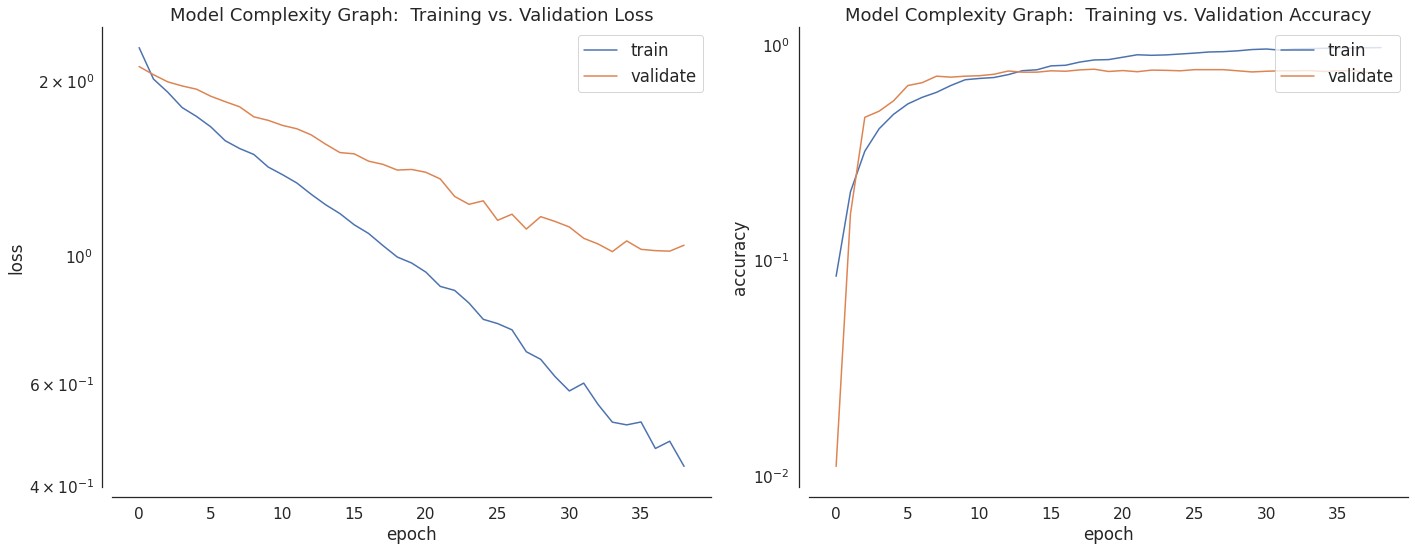

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

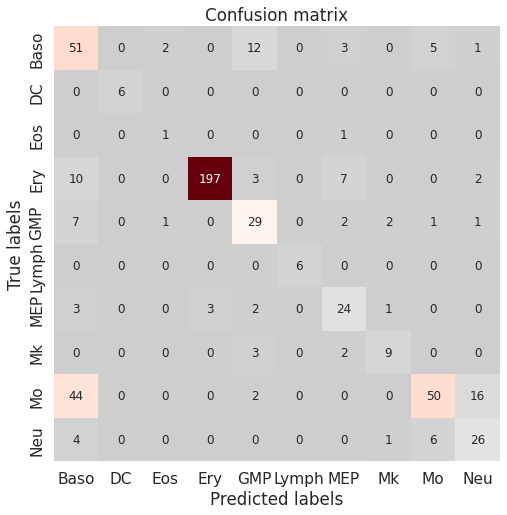

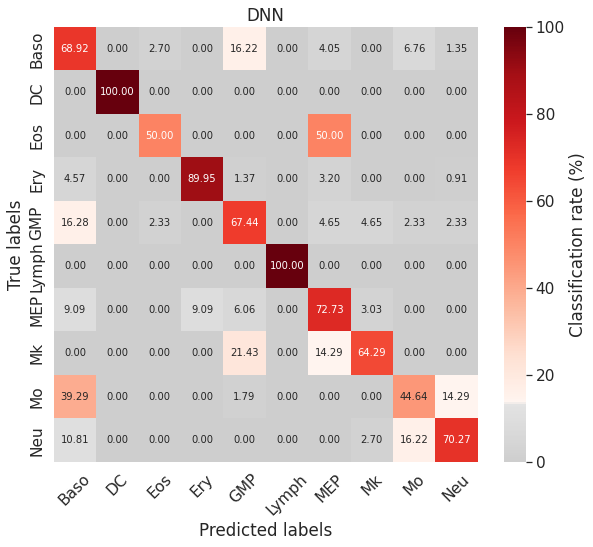

              precision    recall  f1-score   support

        Baso       0.43      0.69      0.53        74
          DC       1.00      1.00      1.00         6
         Eos       0.25      0.50      0.33         2
         Ery       0.98      0.90      0.94       219
         GMP       0.57      0.67      0.62        43
       Lymph       1.00      1.00      1.00         6
         MEP       0.62      0.73      0.67        33
          Mk       0.69      0.64      0.67        14
          Mo       0.81      0.45      0.57       112
         Neu       0.57      0.70      0.63        37

    accuracy                           0.73       546
   macro avg       0.69      0.73      0.70       546
weighted avg       0.78      0.73      0.74       546

18/18 [==============================] - 0s 1ms/step - loss: 1.0142 - accuracy: 0.7546 - auc: 0.9680 - precision: 0.9467 - recall: 0.4231


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


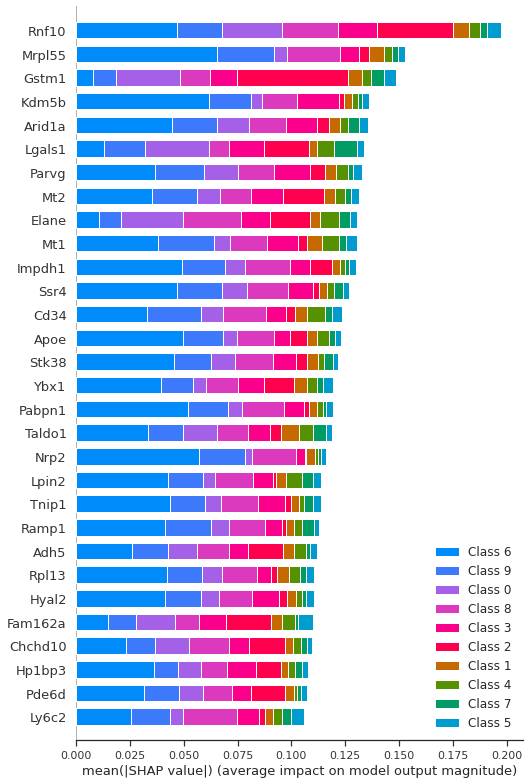

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                99648     
_________________________________________________________________
batch_normalization_4 (Batch (None, 32)                128       
_________________________________________________________________
activation_4 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_5 (Batch (None, 16)                64        
_________________________________________________________________
activation_5 (Activation)    (None

22/22 [==============================] - 0s 4ms/step - loss: 0.9927 - accuracy: 0.8452 - auc: 0.9824 - precision: 1.0000 - recall: 0.0861 - val_loss: 1.4022 - val_accuracy: 0.7656 - val_auc: 0.9643 - val_precision: 1.0000 - val_recall: 0.0220

Epoch 00019: val_loss improved from 1.43424 to 1.40224, saving model to weights/best_model_annotation.h5
Epoch 20/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9695 - accuracy: 0.8484 - auc: 0.9860 - precision: 1.0000 - recall: 0.0929 - val_loss: 1.4055 - val_accuracy: 0.7473 - val_auc: 0.9603 - val_precision: 1.0000 - val_recall: 0.0238

Epoch 00020: val_loss did not improve from 1.40224
Epoch 21/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9347 - accuracy: 0.8704 - auc: 0.9854 - precision: 0.9964 - recall: 0.1282 - val_loss: 1.3897 - val_accuracy: 0.7546 - val_auc: 0.9601 - val_precision: 1.0000 - val_recall: 0.0275

Epoch 00021: val_loss improved from 1.40224 to 1.38969, saving model to weights/best_m

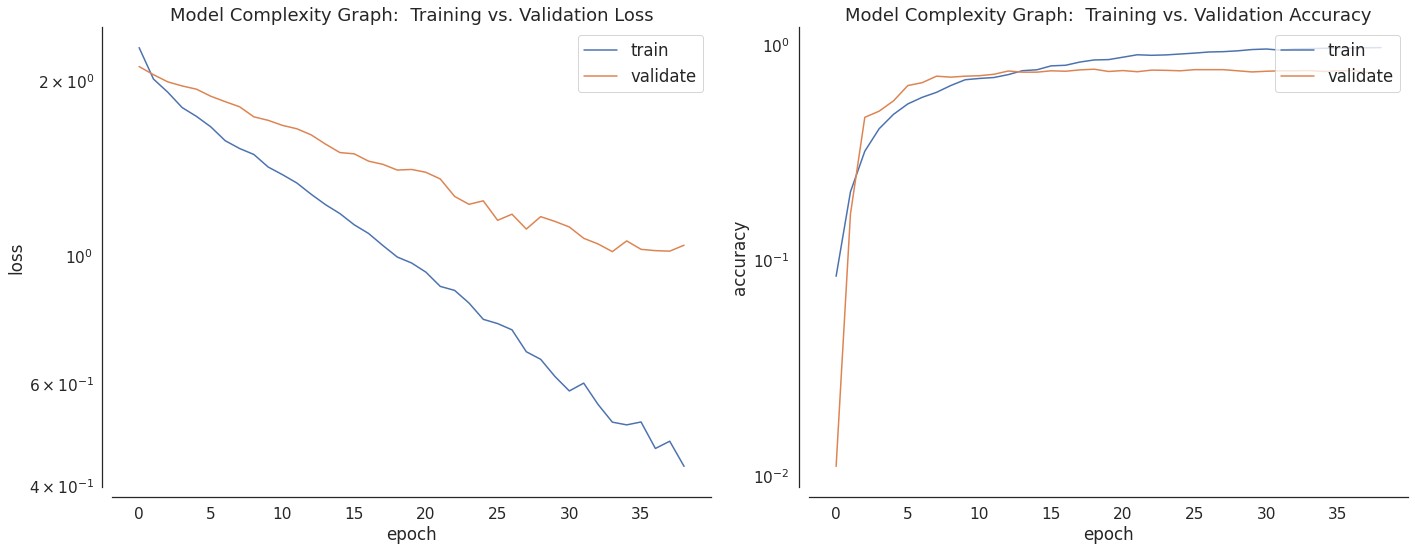

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

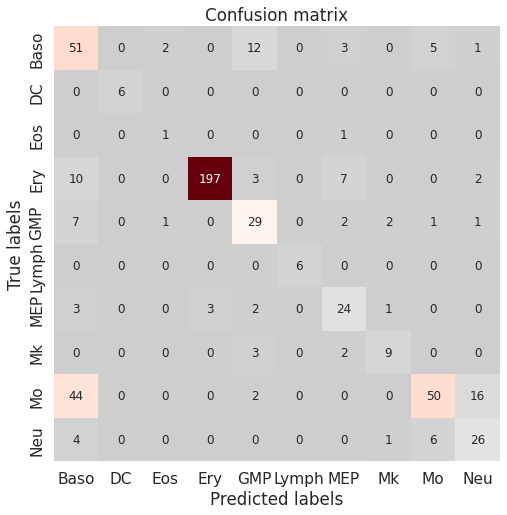

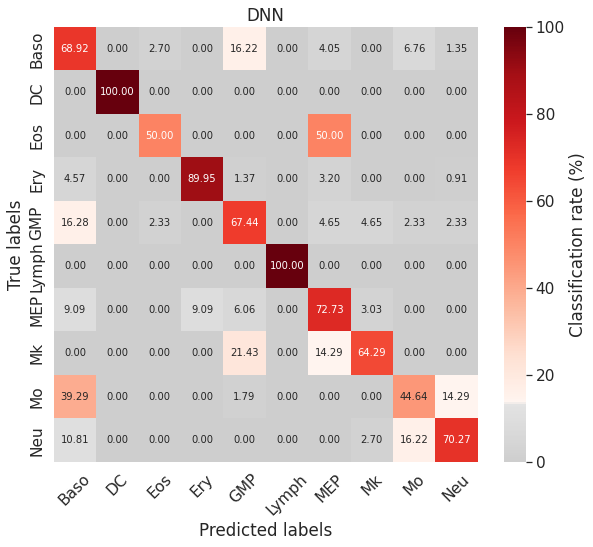

              precision    recall  f1-score   support

        Baso       0.43      0.69      0.53        74
          DC       1.00      1.00      1.00         6
         Eos       0.25      0.50      0.33         2
         Ery       0.98      0.90      0.94       219
         GMP       0.57      0.67      0.62        43
       Lymph       1.00      1.00      1.00         6
         MEP       0.62      0.73      0.67        33
          Mk       0.69      0.64      0.67        14
          Mo       0.81      0.45      0.57       112
         Neu       0.57      0.70      0.63        37

    accuracy                           0.73       546
   macro avg       0.69      0.73      0.70       546
weighted avg       0.78      0.73      0.74       546

18/18 [==============================] - 0s 1ms/step - loss: 1.0142 - accuracy: 0.7546 - auc: 0.9680 - precision: 0.9467 - recall: 0.4231


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


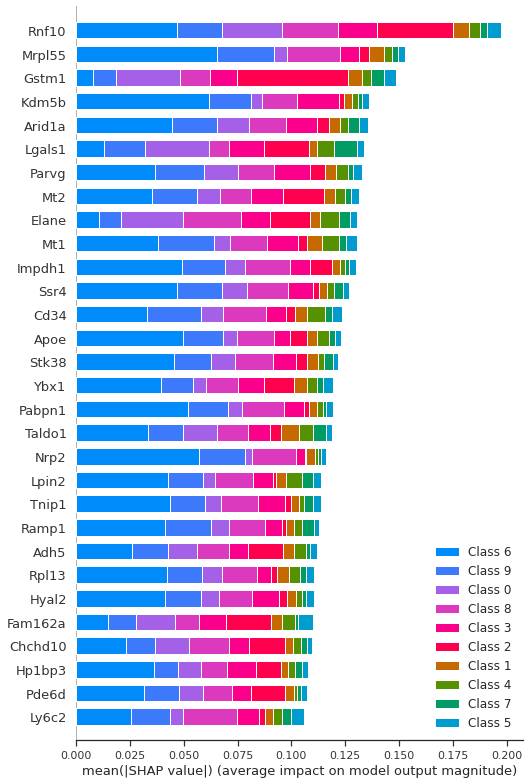

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                99648     
_________________________________________________________________
batch_normalization_8 (Batch (None, 32)                128       
_________________________________________________________________
activation_8 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_9 (Batch (None, 16)                64        
_________________________________________________________________
activation_9 (Activation)    (None

22/22 [==============================] - 0s 4ms/step - loss: 0.9927 - accuracy: 0.8452 - auc: 0.9824 - precision: 1.0000 - recall: 0.0861 - val_loss: 1.4022 - val_accuracy: 0.7656 - val_auc: 0.9643 - val_precision: 1.0000 - val_recall: 0.0220

Epoch 00019: val_loss improved from 1.43424 to 1.40224, saving model to weights/best_model_annotation.h5
Epoch 20/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9695 - accuracy: 0.8484 - auc: 0.9860 - precision: 1.0000 - recall: 0.0929 - val_loss: 1.4055 - val_accuracy: 0.7473 - val_auc: 0.9603 - val_precision: 1.0000 - val_recall: 0.0238

Epoch 00020: val_loss did not improve from 1.40224
Epoch 21/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9347 - accuracy: 0.8704 - auc: 0.9854 - precision: 0.9964 - recall: 0.1282 - val_loss: 1.3897 - val_accuracy: 0.7546 - val_auc: 0.9601 - val_precision: 1.0000 - val_recall: 0.0275

Epoch 00021: val_loss improved from 1.40224 to 1.38969, saving model to weights/best_m

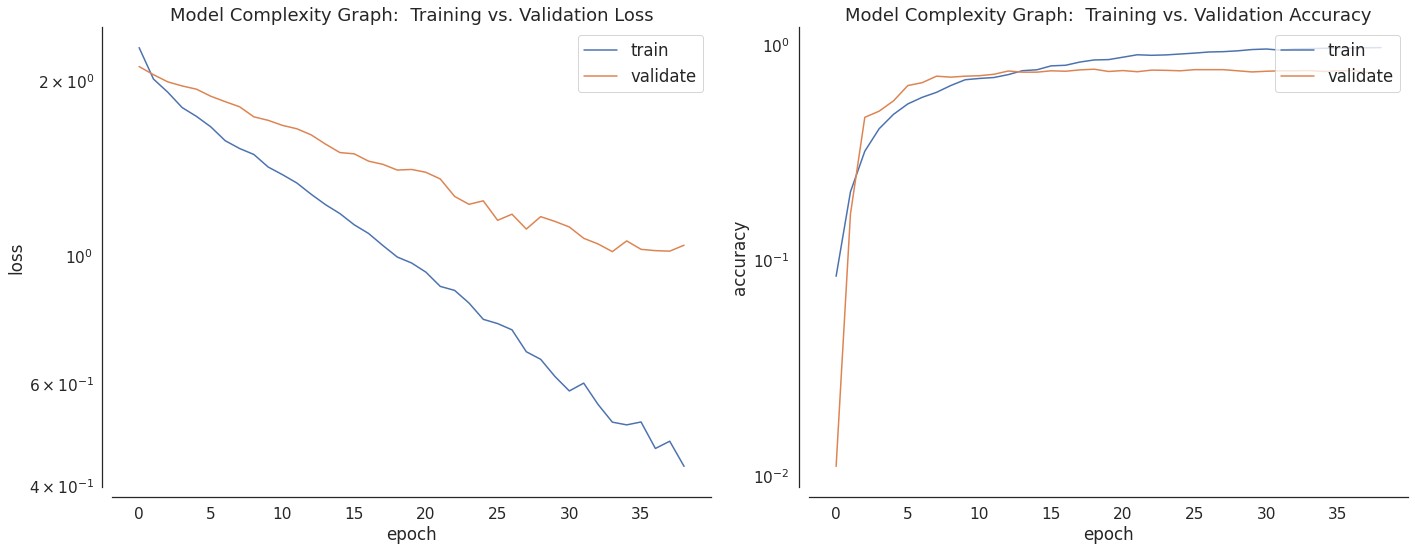

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

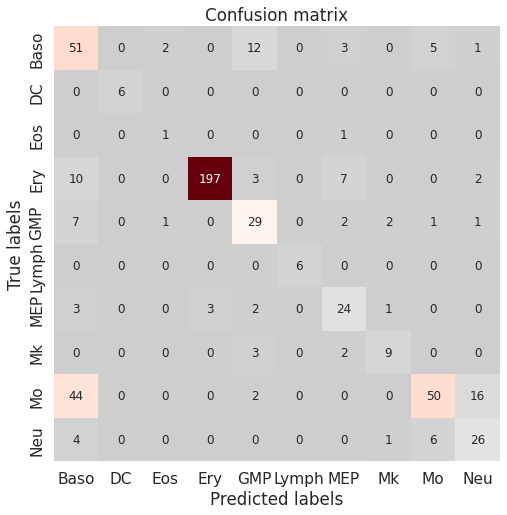

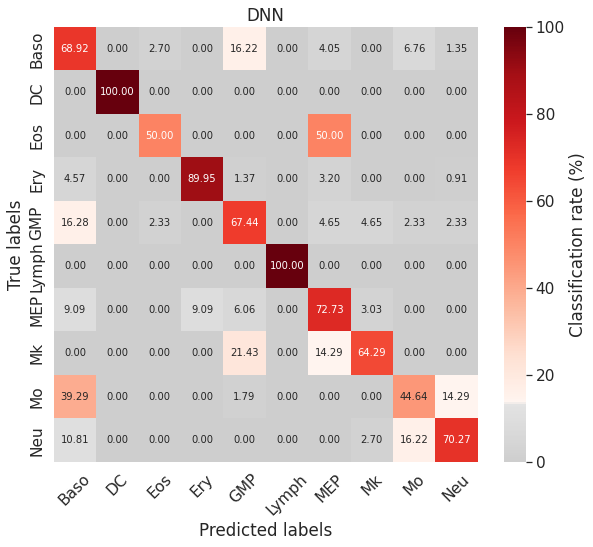

              precision    recall  f1-score   support

        Baso       0.43      0.69      0.53        74
          DC       1.00      1.00      1.00         6
         Eos       0.25      0.50      0.33         2
         Ery       0.98      0.90      0.94       219
         GMP       0.57      0.67      0.62        43
       Lymph       1.00      1.00      1.00         6
         MEP       0.62      0.73      0.67        33
          Mk       0.69      0.64      0.67        14
          Mo       0.81      0.45      0.57       112
         Neu       0.57      0.70      0.63        37

    accuracy                           0.73       546
   macro avg       0.69      0.73      0.70       546
weighted avg       0.78      0.73      0.74       546

18/18 [==============================] - 0s 1ms/step - loss: 1.0142 - accuracy: 0.7546 - auc: 0.9680 - precision: 0.9467 - recall: 0.4231


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


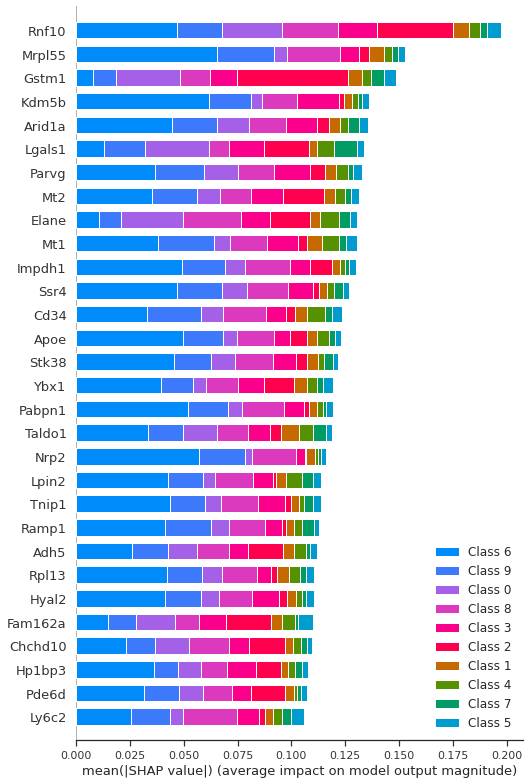

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 32)                99648     
_________________________________________________________________
batch_normalization_12 (Batc (None, 32)                128       
_________________________________________________________________
activation_12 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_13 (Batc (None, 16)                64        
_________________________________________________________________
activation_13 (Activation)   (None

22/22 [==============================] - 0s 4ms/step - loss: 0.9927 - accuracy: 0.8452 - auc: 0.9824 - precision: 1.0000 - recall: 0.0861 - val_loss: 1.4022 - val_accuracy: 0.7656 - val_auc: 0.9643 - val_precision: 1.0000 - val_recall: 0.0220

Epoch 00019: val_loss improved from 1.43424 to 1.40224, saving model to weights/best_model_annotation.h5
Epoch 20/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9695 - accuracy: 0.8484 - auc: 0.9860 - precision: 1.0000 - recall: 0.0929 - val_loss: 1.4055 - val_accuracy: 0.7473 - val_auc: 0.9603 - val_precision: 1.0000 - val_recall: 0.0238

Epoch 00020: val_loss did not improve from 1.40224
Epoch 21/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9347 - accuracy: 0.8704 - auc: 0.9854 - precision: 0.9964 - recall: 0.1282 - val_loss: 1.3897 - val_accuracy: 0.7546 - val_auc: 0.9601 - val_precision: 1.0000 - val_recall: 0.0275

Epoch 00021: val_loss improved from 1.40224 to 1.38969, saving model to weights/best_m

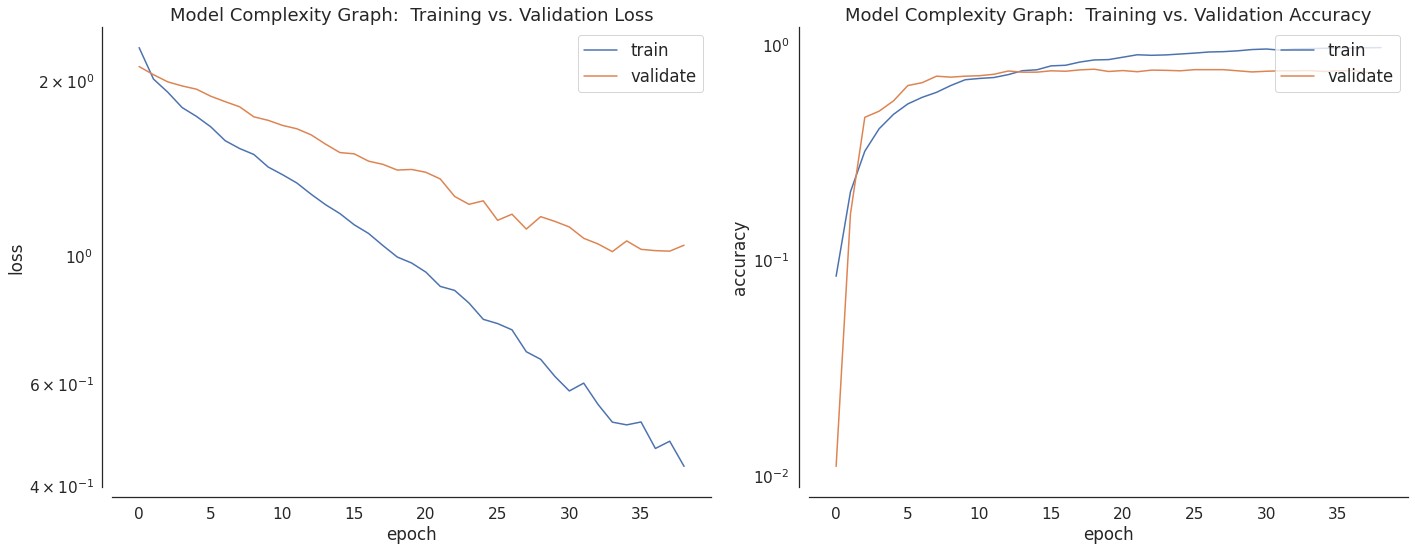

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

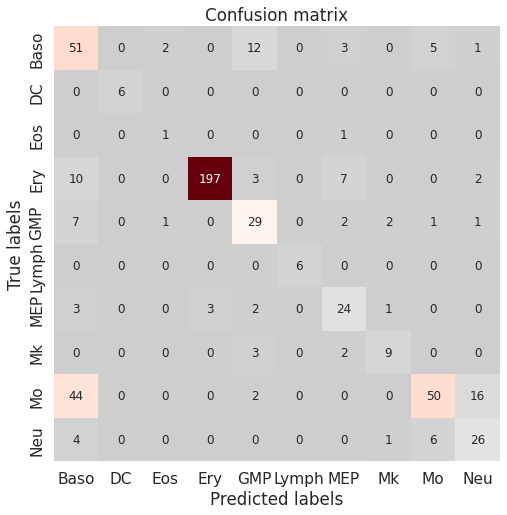

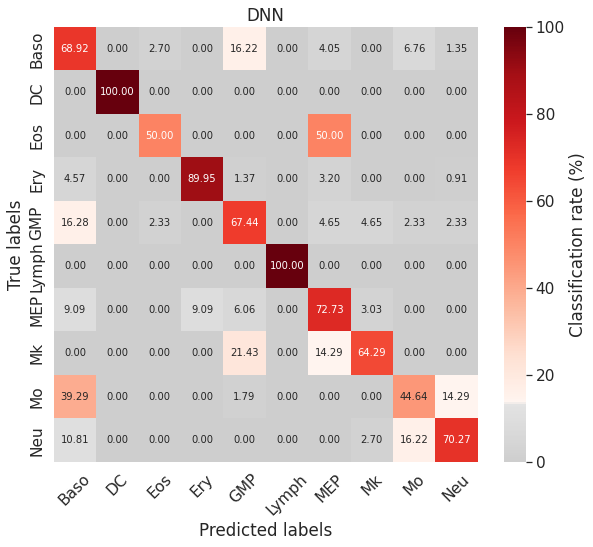

              precision    recall  f1-score   support

        Baso       0.43      0.69      0.53        74
          DC       1.00      1.00      1.00         6
         Eos       0.25      0.50      0.33         2
         Ery       0.98      0.90      0.94       219
         GMP       0.57      0.67      0.62        43
       Lymph       1.00      1.00      1.00         6
         MEP       0.62      0.73      0.67        33
          Mk       0.69      0.64      0.67        14
          Mo       0.81      0.45      0.57       112
         Neu       0.57      0.70      0.63        37

    accuracy                           0.73       546
   macro avg       0.69      0.73      0.70       546
weighted avg       0.78      0.73      0.74       546

18/18 [==============================] - 0s 1ms/step - loss: 1.0142 - accuracy: 0.7546 - auc: 0.9680 - precision: 0.9467 - recall: 0.4231


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


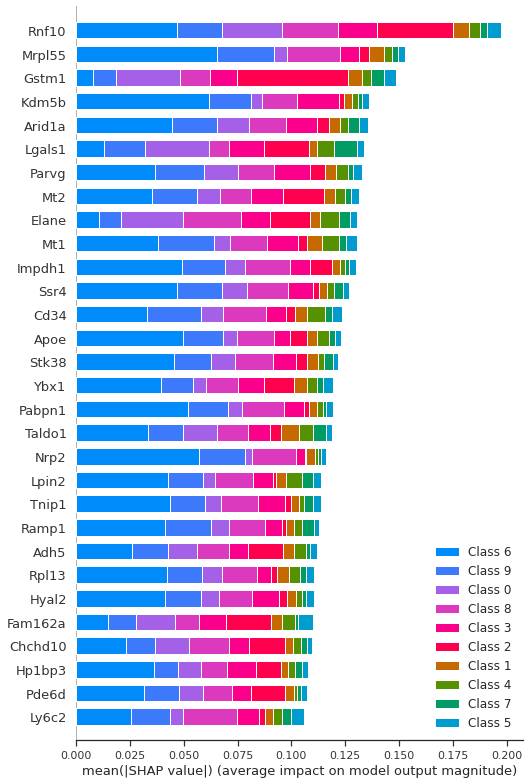

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 32)                99648     
_________________________________________________________________
batch_normalization_16 (Batc (None, 32)                128       
_________________________________________________________________
activation_16 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_17 (Batc (None, 16)                64        
_________________________________________________________________
activation_17 (Activation)   (None

22/22 [==============================] - 0s 4ms/step - loss: 0.9927 - accuracy: 0.8452 - auc: 0.9824 - precision: 1.0000 - recall: 0.0861 - val_loss: 1.4022 - val_accuracy: 0.7656 - val_auc: 0.9643 - val_precision: 1.0000 - val_recall: 0.0220

Epoch 00019: val_loss improved from 1.43424 to 1.40224, saving model to weights/best_model_annotation.h5
Epoch 20/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9695 - accuracy: 0.8484 - auc: 0.9860 - precision: 1.0000 - recall: 0.0929 - val_loss: 1.4055 - val_accuracy: 0.7473 - val_auc: 0.9603 - val_precision: 1.0000 - val_recall: 0.0238

Epoch 00020: val_loss did not improve from 1.40224
Epoch 21/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9347 - accuracy: 0.8704 - auc: 0.9854 - precision: 0.9964 - recall: 0.1282 - val_loss: 1.3897 - val_accuracy: 0.7546 - val_auc: 0.9601 - val_precision: 1.0000 - val_recall: 0.0275

Epoch 00021: val_loss improved from 1.40224 to 1.38969, saving model to weights/best_m

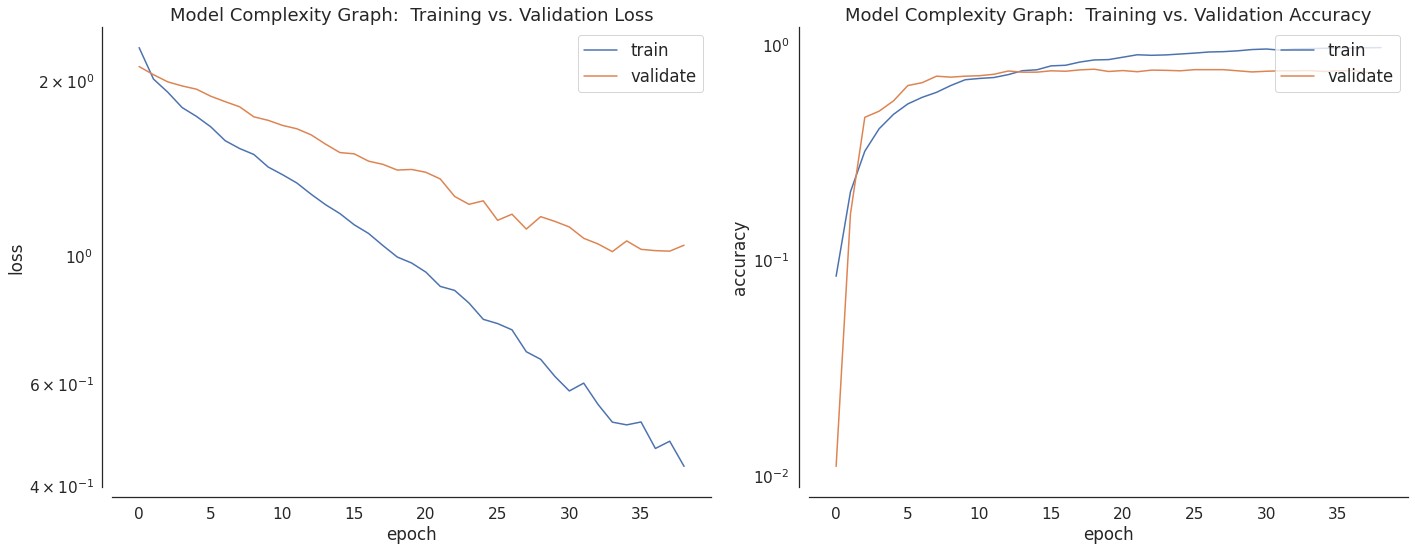

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

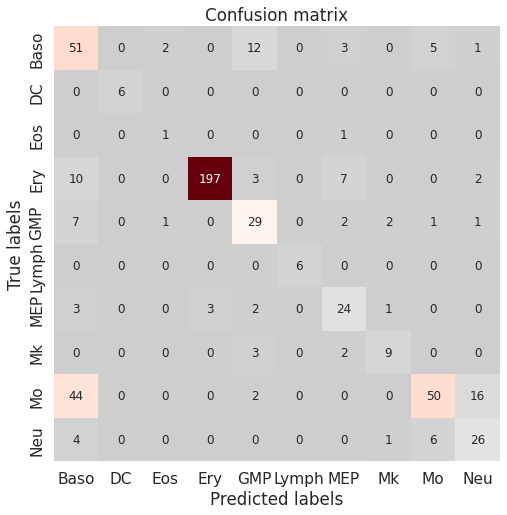

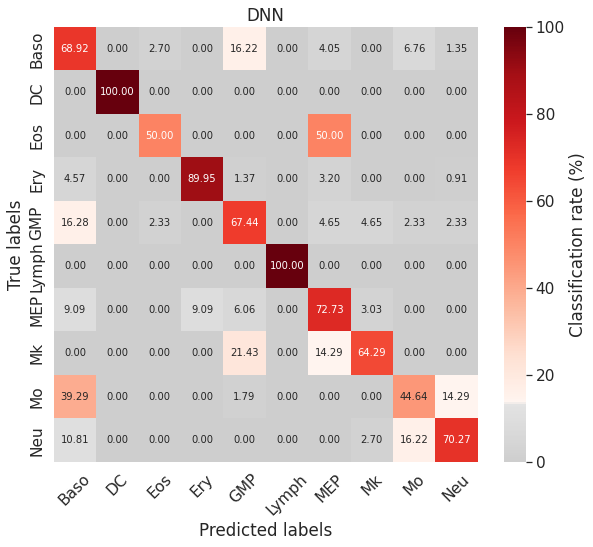

              precision    recall  f1-score   support

        Baso       0.43      0.69      0.53        74
          DC       1.00      1.00      1.00         6
         Eos       0.25      0.50      0.33         2
         Ery       0.98      0.90      0.94       219
         GMP       0.57      0.67      0.62        43
       Lymph       1.00      1.00      1.00         6
         MEP       0.62      0.73      0.67        33
          Mk       0.69      0.64      0.67        14
          Mo       0.81      0.45      0.57       112
         Neu       0.57      0.70      0.63        37

    accuracy                           0.73       546
   macro avg       0.69      0.73      0.70       546
weighted avg       0.78      0.73      0.74       546

18/18 [==============================] - 0s 1ms/step - loss: 1.0142 - accuracy: 0.7546 - auc: 0.9680 - precision: 0.9467 - recall: 0.4231


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


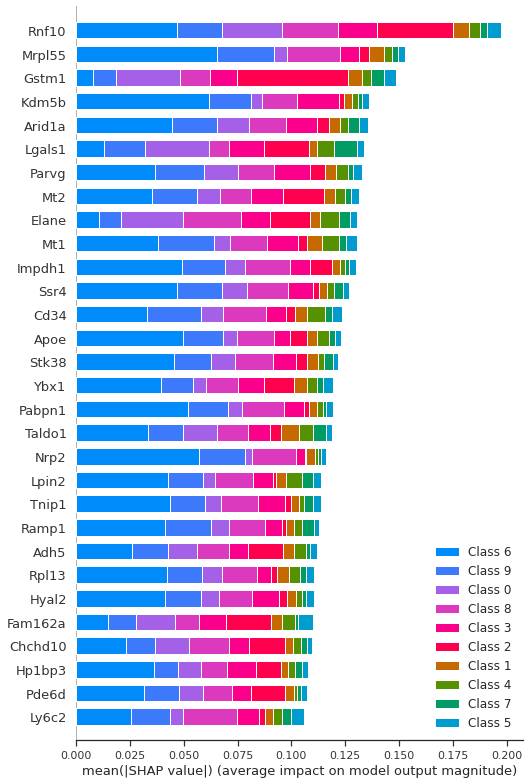

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 32)                99648     
_________________________________________________________________
batch_normalization_20 (Batc (None, 32)                128       
_________________________________________________________________
activation_20 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_21 (Batc (None, 16)                64        
_________________________________________________________________
activation_21 (Activation)   (Non

22/22 [==============================] - 0s 4ms/step - loss: 0.9927 - accuracy: 0.8452 - auc: 0.9824 - precision: 1.0000 - recall: 0.0861 - val_loss: 1.4022 - val_accuracy: 0.7656 - val_auc: 0.9643 - val_precision: 1.0000 - val_recall: 0.0220

Epoch 00019: val_loss improved from 1.43424 to 1.40224, saving model to weights/best_model_annotation.h5
Epoch 20/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9695 - accuracy: 0.8484 - auc: 0.9860 - precision: 1.0000 - recall: 0.0929 - val_loss: 1.4055 - val_accuracy: 0.7473 - val_auc: 0.9603 - val_precision: 1.0000 - val_recall: 0.0238

Epoch 00020: val_loss did not improve from 1.40224
Epoch 21/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9347 - accuracy: 0.8704 - auc: 0.9854 - precision: 0.9964 - recall: 0.1282 - val_loss: 1.3897 - val_accuracy: 0.7546 - val_auc: 0.9601 - val_precision: 1.0000 - val_recall: 0.0275

Epoch 00021: val_loss improved from 1.40224 to 1.38969, saving model to weights/best_m

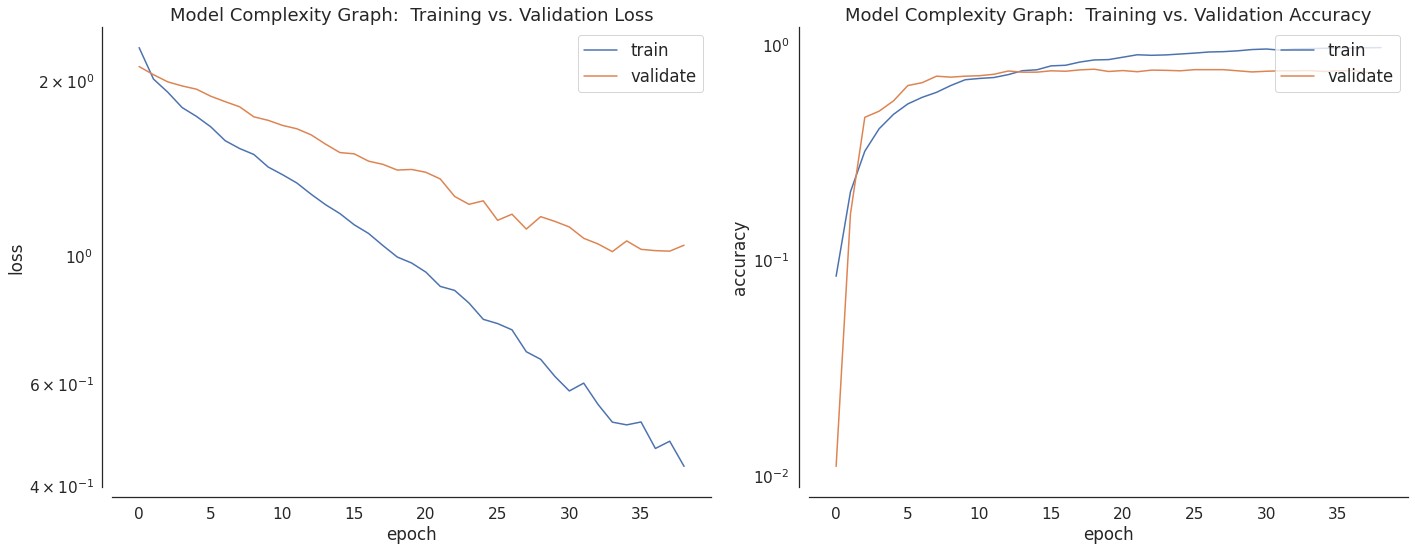

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

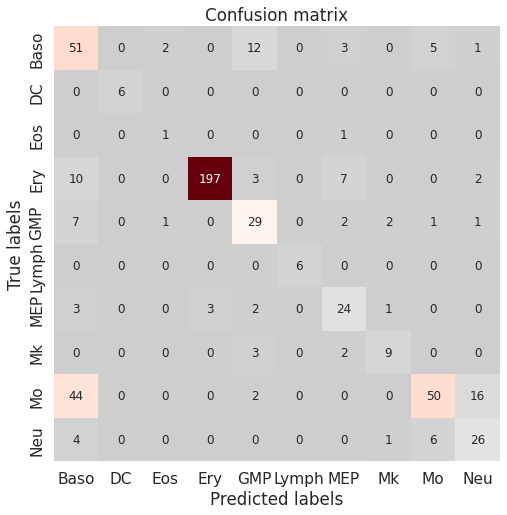

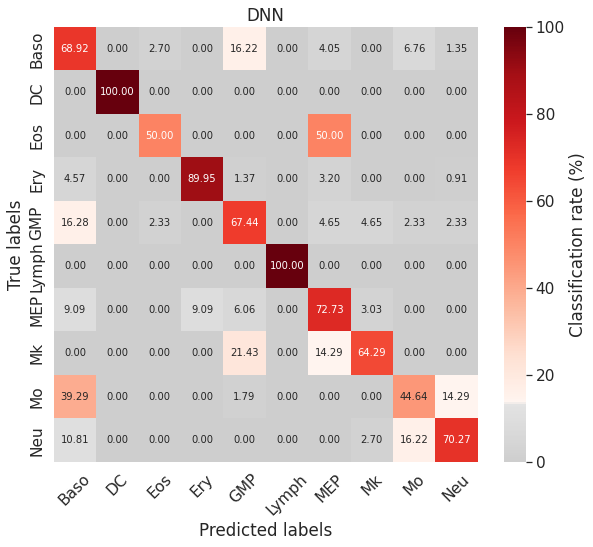

              precision    recall  f1-score   support

        Baso       0.43      0.69      0.53        74
          DC       1.00      1.00      1.00         6
         Eos       0.25      0.50      0.33         2
         Ery       0.98      0.90      0.94       219
         GMP       0.57      0.67      0.62        43
       Lymph       1.00      1.00      1.00         6
         MEP       0.62      0.73      0.67        33
          Mk       0.69      0.64      0.67        14
          Mo       0.81      0.45      0.57       112
         Neu       0.57      0.70      0.63        37

    accuracy                           0.73       546
   macro avg       0.69      0.73      0.70       546
weighted avg       0.78      0.73      0.74       546

18/18 [==============================] - 0s 1ms/step - loss: 1.0142 - accuracy: 0.7546 - auc: 0.9680 - precision: 0.9467 - recall: 0.4231


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


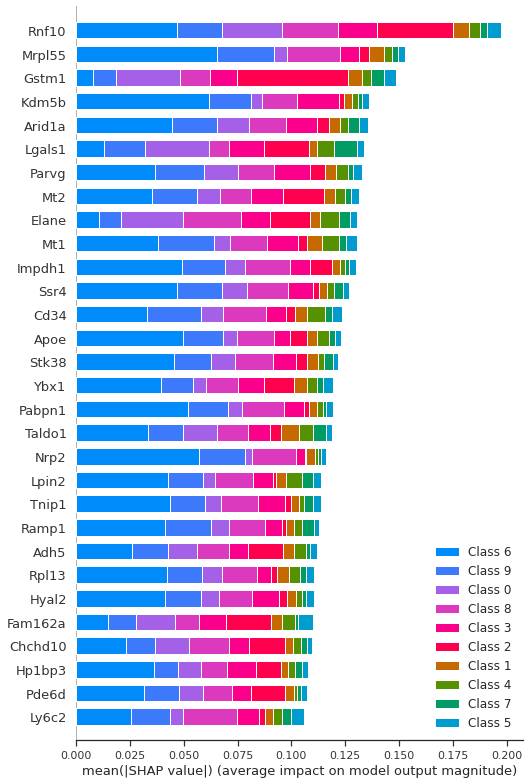

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 32)                99648     
_________________________________________________________________
batch_normalization_24 (Batc (None, 32)                128       
_________________________________________________________________
activation_24 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_25 (Batc (None, 16)                64        
_________________________________________________________________
activation_25 (Activation)   (Non

22/22 [==============================] - 0s 4ms/step - loss: 0.9927 - accuracy: 0.8452 - auc: 0.9824 - precision: 1.0000 - recall: 0.0861 - val_loss: 1.4022 - val_accuracy: 0.7656 - val_auc: 0.9643 - val_precision: 1.0000 - val_recall: 0.0220

Epoch 00019: val_loss improved from 1.43424 to 1.40224, saving model to weights/best_model_annotation.h5
Epoch 20/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9695 - accuracy: 0.8484 - auc: 0.9860 - precision: 1.0000 - recall: 0.0929 - val_loss: 1.4055 - val_accuracy: 0.7473 - val_auc: 0.9603 - val_precision: 1.0000 - val_recall: 0.0238

Epoch 00020: val_loss did not improve from 1.40224
Epoch 21/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9347 - accuracy: 0.8704 - auc: 0.9854 - precision: 0.9964 - recall: 0.1282 - val_loss: 1.3897 - val_accuracy: 0.7546 - val_auc: 0.9601 - val_precision: 1.0000 - val_recall: 0.0275

Epoch 00021: val_loss improved from 1.40224 to 1.38969, saving model to weights/best_m

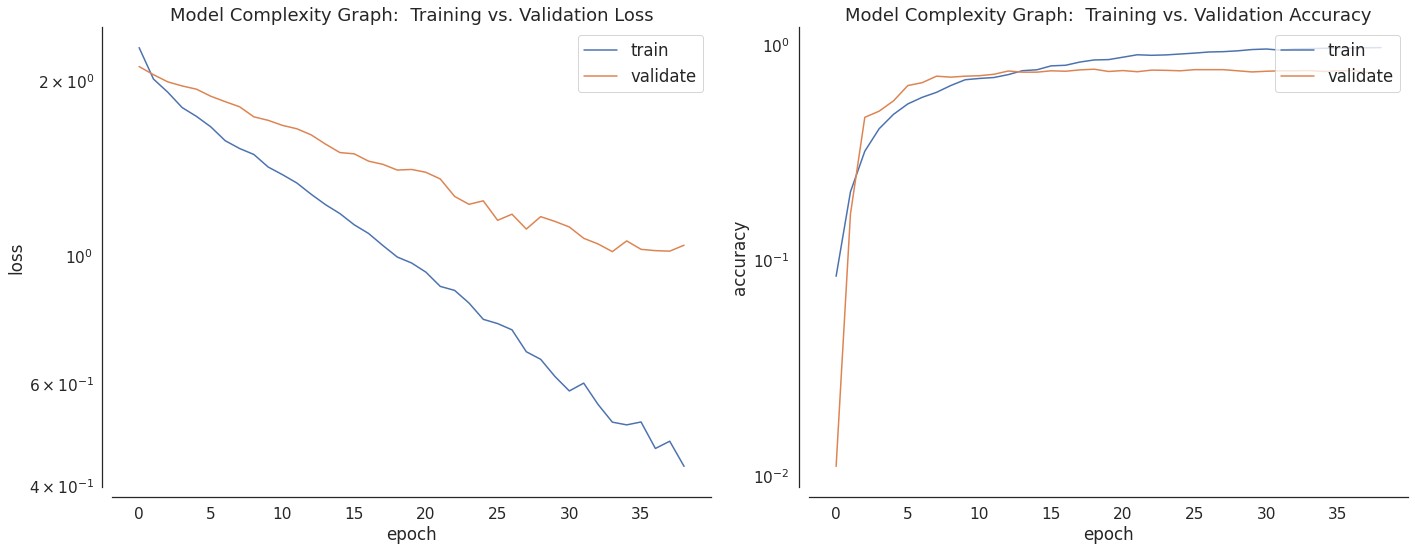

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

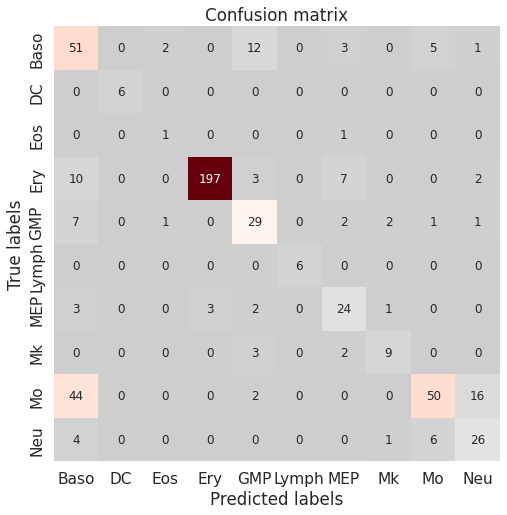

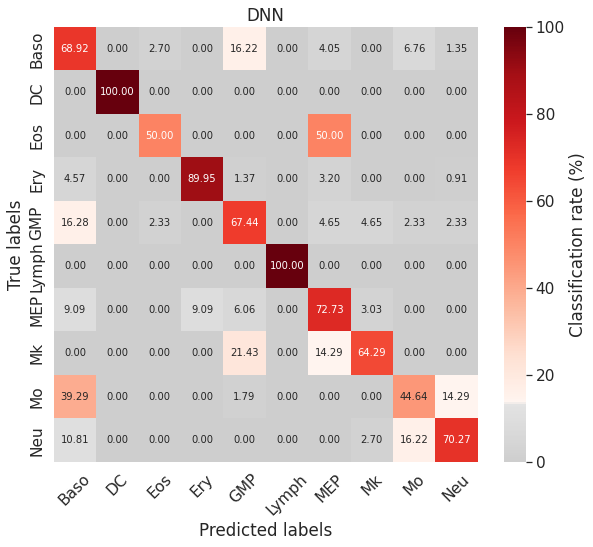

              precision    recall  f1-score   support

        Baso       0.43      0.69      0.53        74
          DC       1.00      1.00      1.00         6
         Eos       0.25      0.50      0.33         2
         Ery       0.98      0.90      0.94       219
         GMP       0.57      0.67      0.62        43
       Lymph       1.00      1.00      1.00         6
         MEP       0.62      0.73      0.67        33
          Mk       0.69      0.64      0.67        14
          Mo       0.81      0.45      0.57       112
         Neu       0.57      0.70      0.63        37

    accuracy                           0.73       546
   macro avg       0.69      0.73      0.70       546
weighted avg       0.78      0.73      0.74       546

18/18 [==============================] - 0s 1ms/step - loss: 1.0142 - accuracy: 0.7546 - auc: 0.9680 - precision: 0.9467 - recall: 0.4231


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


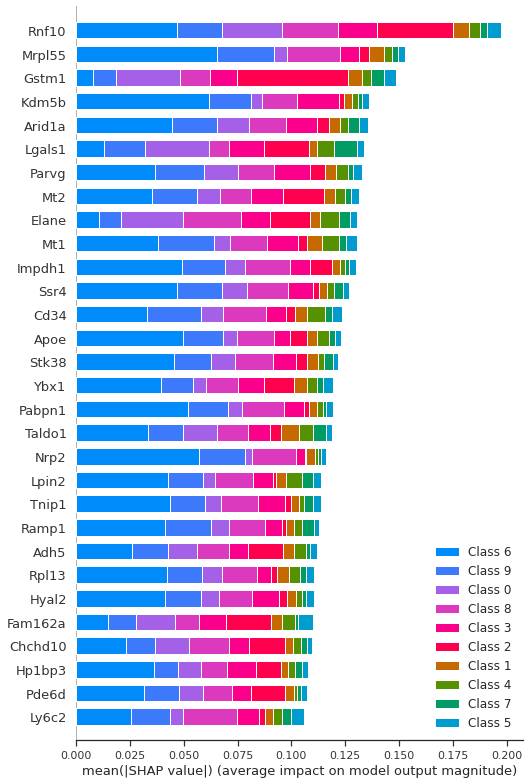

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 32)                99648     
_________________________________________________________________
batch_normalization_28 (Batc (None, 32)                128       
_________________________________________________________________
activation_28 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_29 (Batc (None, 16)                64        
_________________________________________________________________
activation_29 (Activation)   (Non

22/22 [==============================] - 0s 4ms/step - loss: 0.9927 - accuracy: 0.8452 - auc: 0.9824 - precision: 1.0000 - recall: 0.0861 - val_loss: 1.4022 - val_accuracy: 0.7656 - val_auc: 0.9643 - val_precision: 1.0000 - val_recall: 0.0220

Epoch 00019: val_loss improved from 1.43424 to 1.40224, saving model to weights/best_model_annotation.h5
Epoch 20/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9695 - accuracy: 0.8484 - auc: 0.9860 - precision: 1.0000 - recall: 0.0929 - val_loss: 1.4055 - val_accuracy: 0.7473 - val_auc: 0.9603 - val_precision: 1.0000 - val_recall: 0.0238

Epoch 00020: val_loss did not improve from 1.40224
Epoch 21/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9347 - accuracy: 0.8704 - auc: 0.9854 - precision: 0.9964 - recall: 0.1282 - val_loss: 1.3897 - val_accuracy: 0.7546 - val_auc: 0.9601 - val_precision: 1.0000 - val_recall: 0.0275

Epoch 00021: val_loss improved from 1.40224 to 1.38969, saving model to weights/best_m

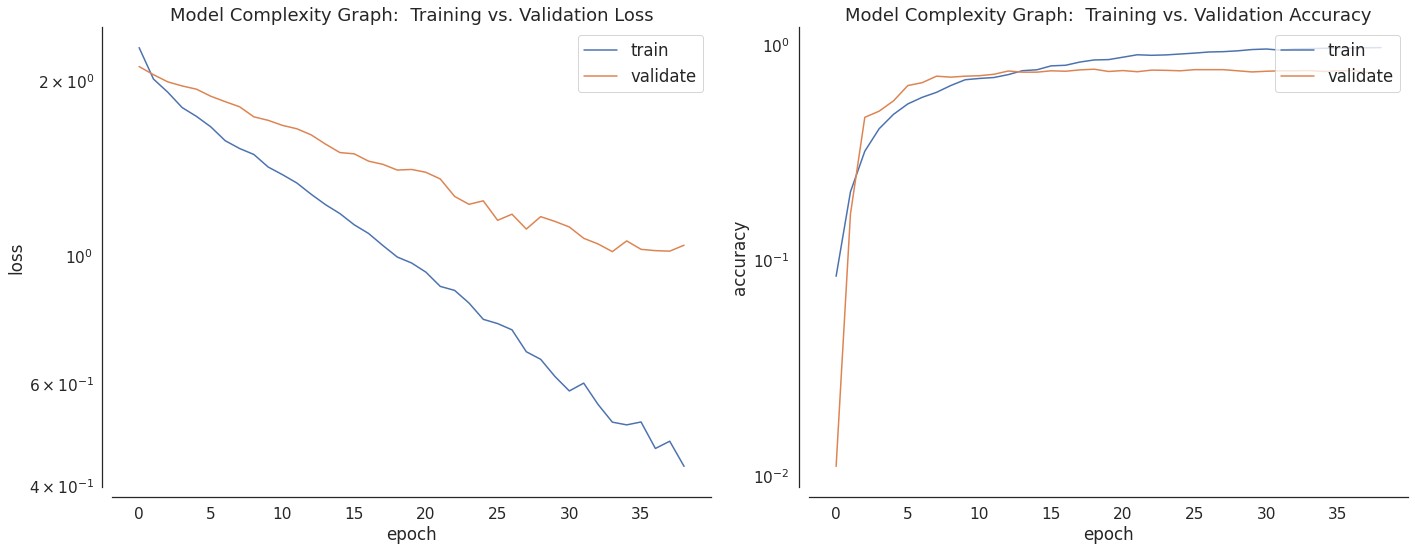

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

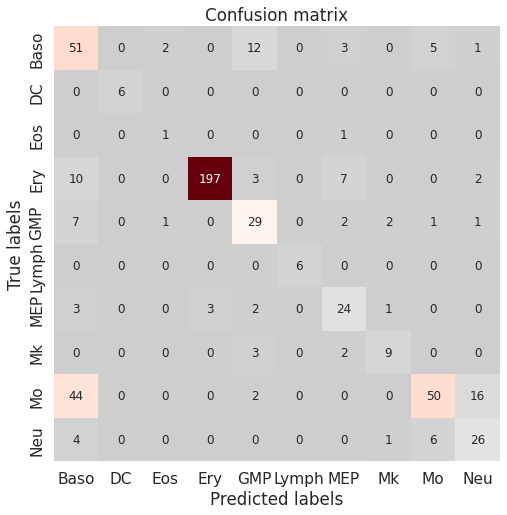

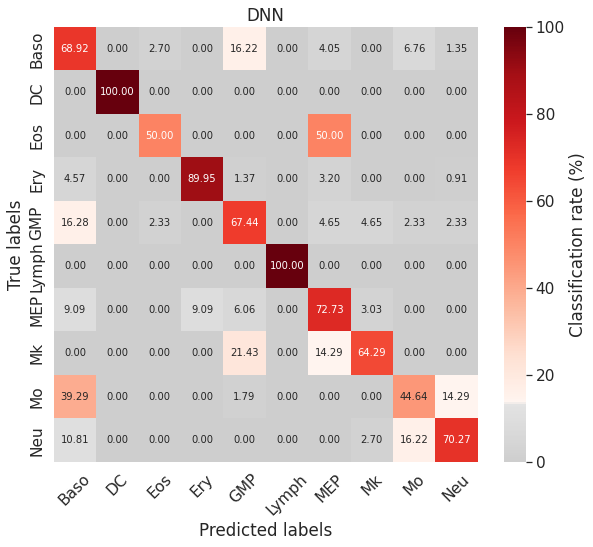

              precision    recall  f1-score   support

        Baso       0.43      0.69      0.53        74
          DC       1.00      1.00      1.00         6
         Eos       0.25      0.50      0.33         2
         Ery       0.98      0.90      0.94       219
         GMP       0.57      0.67      0.62        43
       Lymph       1.00      1.00      1.00         6
         MEP       0.62      0.73      0.67        33
          Mk       0.69      0.64      0.67        14
          Mo       0.81      0.45      0.57       112
         Neu       0.57      0.70      0.63        37

    accuracy                           0.73       546
   macro avg       0.69      0.73      0.70       546
weighted avg       0.78      0.73      0.74       546

18/18 [==============================] - 0s 1ms/step - loss: 1.0142 - accuracy: 0.7546 - auc: 0.9680 - precision: 0.9467 - recall: 0.4231


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


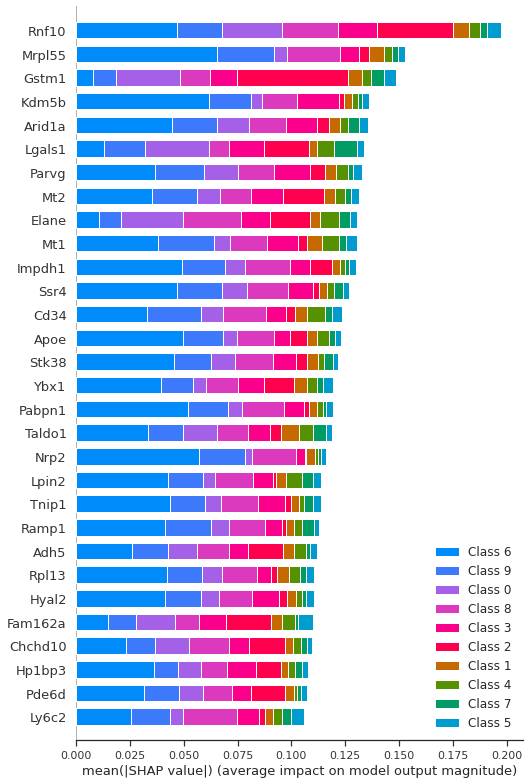

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 32)                99648     
_________________________________________________________________
batch_normalization_32 (Batc (None, 32)                128       
_________________________________________________________________
activation_32 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_33 (Batc (None, 16)                64        
_________________________________________________________________
activation_33 (Activation)   (Non

22/22 [==============================] - 0s 4ms/step - loss: 0.9927 - accuracy: 0.8452 - auc: 0.9824 - precision: 1.0000 - recall: 0.0861 - val_loss: 1.4022 - val_accuracy: 0.7656 - val_auc: 0.9643 - val_precision: 1.0000 - val_recall: 0.0220

Epoch 00019: val_loss improved from 1.43424 to 1.40224, saving model to weights/best_model_annotation.h5
Epoch 20/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9695 - accuracy: 0.8484 - auc: 0.9860 - precision: 1.0000 - recall: 0.0929 - val_loss: 1.4055 - val_accuracy: 0.7473 - val_auc: 0.9603 - val_precision: 1.0000 - val_recall: 0.0238

Epoch 00020: val_loss did not improve from 1.40224
Epoch 21/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9347 - accuracy: 0.8704 - auc: 0.9854 - precision: 0.9964 - recall: 0.1282 - val_loss: 1.3897 - val_accuracy: 0.7546 - val_auc: 0.9601 - val_precision: 1.0000 - val_recall: 0.0275

Epoch 00021: val_loss improved from 1.40224 to 1.38969, saving model to weights/best_m

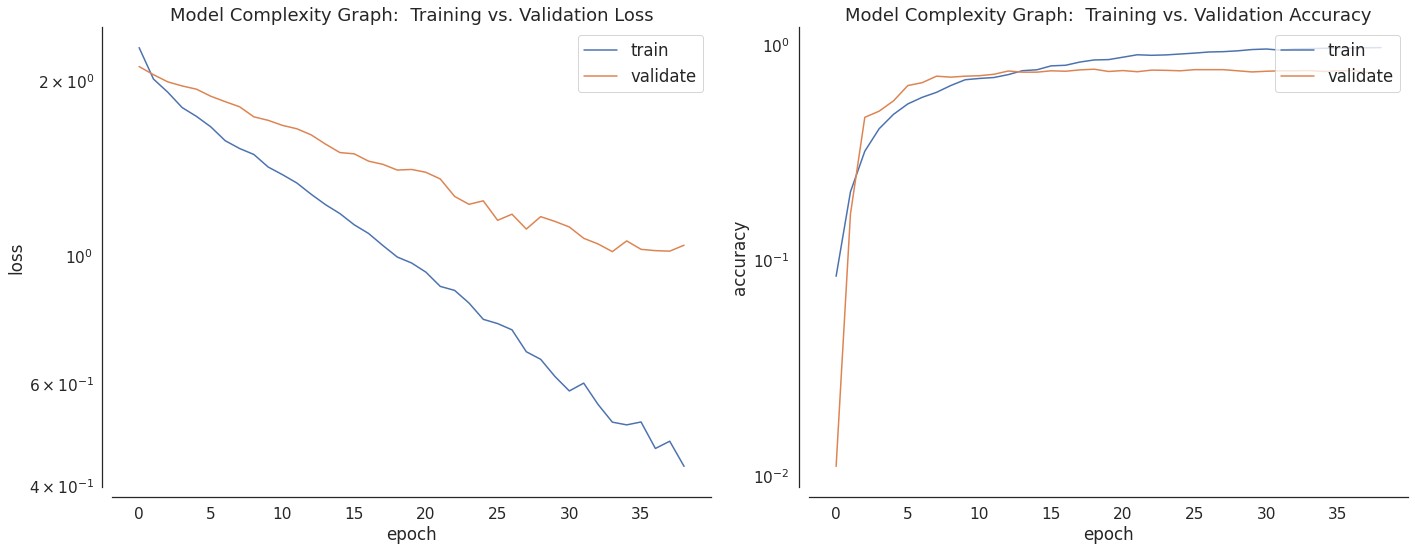

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

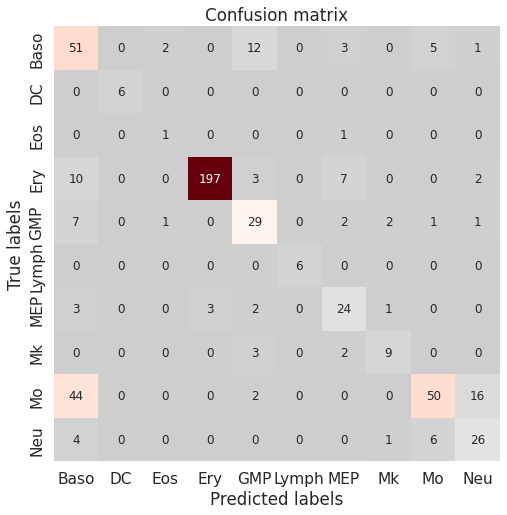

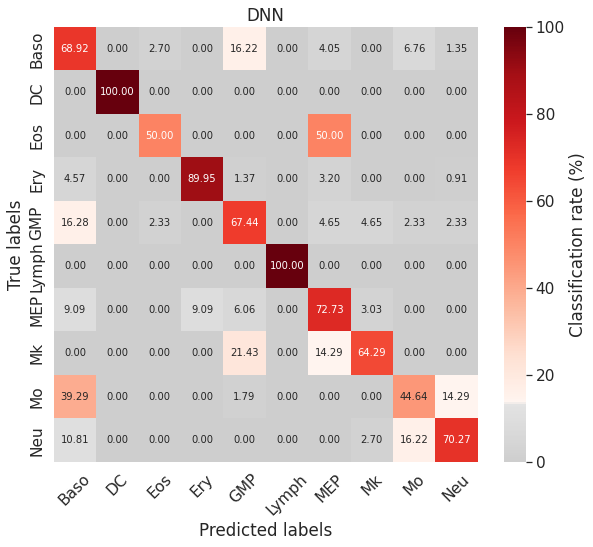

              precision    recall  f1-score   support

        Baso       0.43      0.69      0.53        74
          DC       1.00      1.00      1.00         6
         Eos       0.25      0.50      0.33         2
         Ery       0.98      0.90      0.94       219
         GMP       0.57      0.67      0.62        43
       Lymph       1.00      1.00      1.00         6
         MEP       0.62      0.73      0.67        33
          Mk       0.69      0.64      0.67        14
          Mo       0.81      0.45      0.57       112
         Neu       0.57      0.70      0.63        37

    accuracy                           0.73       546
   macro avg       0.69      0.73      0.70       546
weighted avg       0.78      0.73      0.74       546

18/18 [==============================] - 0s 1ms/step - loss: 1.0142 - accuracy: 0.7546 - auc: 0.9680 - precision: 0.9467 - recall: 0.4231


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


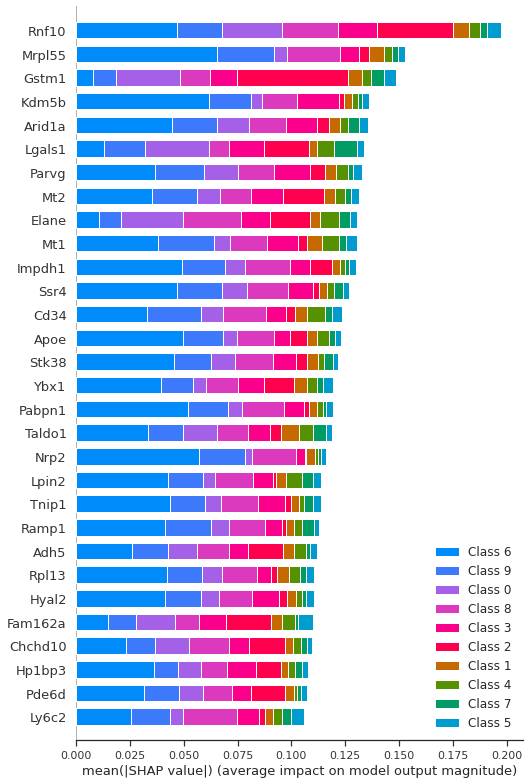

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 32)                99648     
_________________________________________________________________
batch_normalization_36 (Batc (None, 32)                128       
_________________________________________________________________
activation_36 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_37 (Batc (None, 16)                64        
_________________________________________________________________
activation_37 (Activation)   (Non

22/22 [==============================] - 0s 4ms/step - loss: 0.9927 - accuracy: 0.8452 - auc: 0.9824 - precision: 1.0000 - recall: 0.0861 - val_loss: 1.4022 - val_accuracy: 0.7656 - val_auc: 0.9643 - val_precision: 1.0000 - val_recall: 0.0220

Epoch 00019: val_loss improved from 1.43424 to 1.40224, saving model to weights/best_model_annotation.h5
Epoch 20/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9695 - accuracy: 0.8484 - auc: 0.9860 - precision: 1.0000 - recall: 0.0929 - val_loss: 1.4055 - val_accuracy: 0.7473 - val_auc: 0.9603 - val_precision: 1.0000 - val_recall: 0.0238

Epoch 00020: val_loss did not improve from 1.40224
Epoch 21/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9347 - accuracy: 0.8704 - auc: 0.9854 - precision: 0.9964 - recall: 0.1282 - val_loss: 1.3897 - val_accuracy: 0.7546 - val_auc: 0.9601 - val_precision: 1.0000 - val_recall: 0.0275

Epoch 00021: val_loss improved from 1.40224 to 1.38969, saving model to weights/best_m

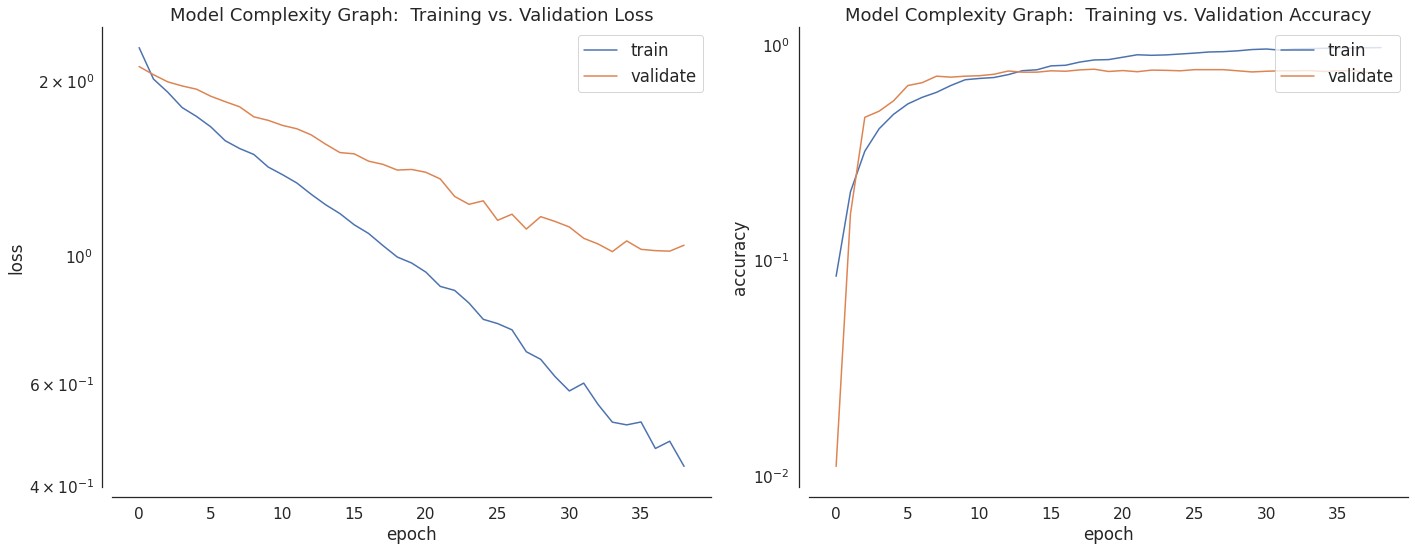

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

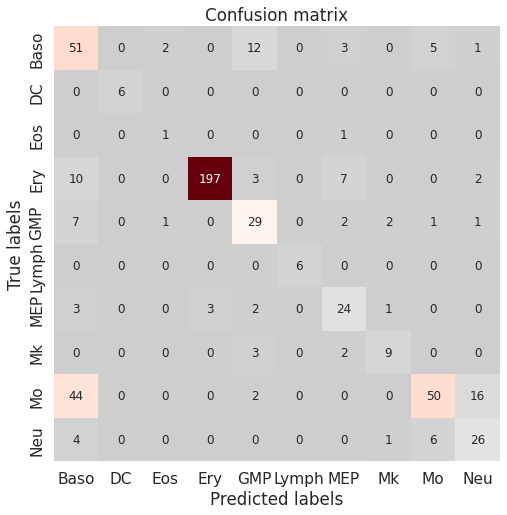

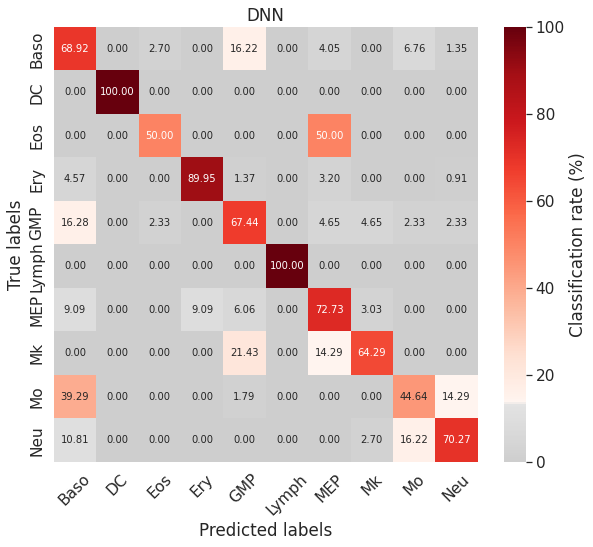

              precision    recall  f1-score   support

        Baso       0.43      0.69      0.53        74
          DC       1.00      1.00      1.00         6
         Eos       0.25      0.50      0.33         2
         Ery       0.98      0.90      0.94       219
         GMP       0.57      0.67      0.62        43
       Lymph       1.00      1.00      1.00         6
         MEP       0.62      0.73      0.67        33
          Mk       0.69      0.64      0.67        14
          Mo       0.81      0.45      0.57       112
         Neu       0.57      0.70      0.63        37

    accuracy                           0.73       546
   macro avg       0.69      0.73      0.70       546
weighted avg       0.78      0.73      0.74       546

18/18 [==============================] - 0s 1ms/step - loss: 1.0142 - accuracy: 0.7546 - auc: 0.9680 - precision: 0.9467 - recall: 0.4231


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


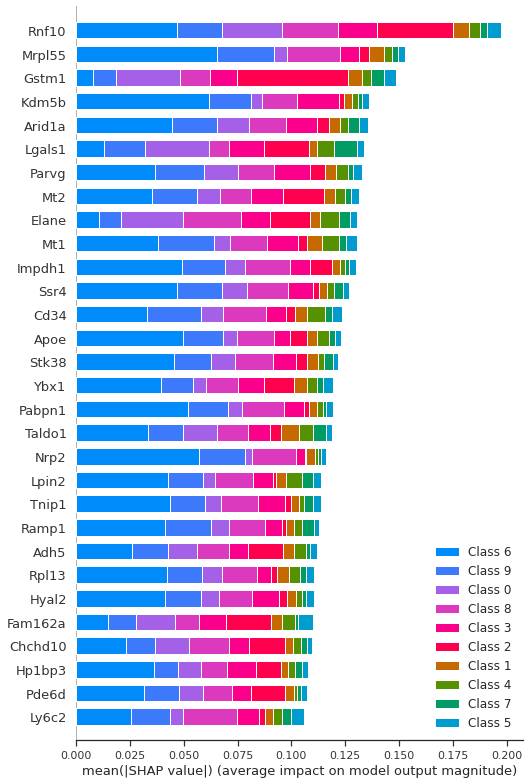

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


CPU times: user 5min 53s, sys: 14.1 s, total: 6min 7s
Wall time: 3min 43s


In [18]:
%%time
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    train_X_y = adata[np.concatenate([train_indices, val_indices]), :]
    sm = smashpy.smashpy()
    sm.DNN(adata, group_by="annotation", model=None, balance=True, verbose=True, save=False)
    selectedGenes, selectedGenes_dict = sm.run_shap(adata, group_by="annotation", model=None, verbose=True, pct=0.1, restrict_top=("global", k))
    # since this selects k per class, need select randomly from each classes
    smash_markers = adata.var.index.get_indexer(selectedGenes)

    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = smash_markers)
    np.save(model_save_path + 'smash_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'smash_markers_{}.npy'.format(tryy), smash_markers)
    np.save(model_save_path + 'experiment_data_folds/smash_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Smash Marker Visualization', path = viz_save_path + 'smash_markers_{}.png'.format(tryy), markers = smash_markers)

## Train RankCorr

In [19]:
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    data = Rocks(X_train, y_train)
    lamb = 4.7# this can be whatever

    rankcorr_markers = data.CSrankMarkers(lamb=lamb, writeOut=False, keepZeros=False, onlyNonZero=False)
    if len(rankcorr_markers) < k:
        raise Exception("Increase lamb for rank corr procedure")
    if len(rankcorr_markers) > k:
        rankcorr_markers = rankcorr_markers[:k]
    geneNames = np.array(adata.var.index)
    data.genes = geneNames
    marker_genes = data.markers_to_genes(rankcorr_markers)
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = rankcorr_markers)
    np.save(model_save_path + 'rankcorr_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'rankcorr_markers_{}.npy'.format(tryy), rankcorr_markers)
    np.save(model_save_path + 'experiment_data_folds/rankcorr_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'RankCorr Marker Visualization', path = viz_save_path + 'rankcorr_markers_{}.png'.format(tryy), markers = rankcorr_markers)

Excess Length of markers
82


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Excess Length of markers
89


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Excess Length of markers
82


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Excess Length of markers
85


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Excess Length of markers
84
Excess Length of markers
83


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Excess Length of markers
80


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Excess Length of markers
87


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Excess Length of markers
82
Excess Length of markers
77


## Train L1 VAE

In [20]:
feature_std = torch.tensor(X).std(dim = 0)
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = VAE_l1_diag(input_size, hidden_layer_size, z_size, batch_norm = batch_norm)
    tmp_path = model_save_path + 'l1_vae_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, min_epochs = 25, 
                     max_epochs = 100, auto_lr = True, early_stopping_patience = 4, precision = precision)
    l1_markers = model.markers(feature_std = feature_std.to(model.device), k = k).clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = l1_markers)
    np.save(model_save_path + 'l1_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'l1_vae_markers_{}.npy'.format(tryy), l1_markers)
    np.save(model_save_path + 'experiment_data_folds/l1_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'L1 VAE Marker Visualization', path = viz_save_path + 'l1_vae_markers_{}.png'.format(tryy), markers = l1_markers)

Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 41.74it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 42.54it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Setting `Trainer(weights_summary=None)` is depre

## Train Global Gate

In [15]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers=num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = VAE_Gumbel_GlobalGate(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay=0.95, batch_norm = batch_norm)
    tmp_path = model_save_path + 'globalgate_vae_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus = gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.00001, early_stopping_patience =  10, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = precision)
    globalgate_markers = model.markers().clone().cpu().detach().numpy()
    
 
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = globalgate_markers)
    np.save(model_save_path + 'globalgate_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'globalgate_vae_markers_{}.npy'.format(tryy), globalgate_markers)
    np.save(model_save_path + 'experiment_data_folds/globalgate_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Global Gate VAE Marker Visualization', path = viz_save_path + 'globalgate_vae_markers_{}.png'.format(tryy), markers = globalgate_markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:03<00:00, 31.81it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:03<00:00, 31.52i

## MarkerMap Unsupervised

In [16]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    model = MarkerMap(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 1.0, num_classes = None)
    tmp_path = model_save_path + 'marker_map_unsupervised_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=1, min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.0001, early_stopping_patience = 4, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = precision)
    unsupervised_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = unsupervised_markers)
    np.save(model_save_path + 'marker_map_unsupervised_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'marker_map_unsupervised_markers_{}.npy'.format(tryy), unsupervised_markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_unsupervised_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Marker Map Unsupervised Marker Visualization', path = viz_save_path + 'marker_map_unsupervised_markers_{}.png'.format(tryy), markers = unsupervised_markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:03<00:00, 28.50it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:03<00:00, 28.68i

## MarkerMap Supervised

In [17]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    
    model = MarkerMap(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                             k = k, t = global_t, bias = True, temperature_decay=0.97, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 0)
    tmp_path = model_save_path + 'marker_map_supervised_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                     min_epochs = 50, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers)
    np.save(model_save_path + 'marker_map_supervised_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'marker_map_supervised_markers_{}.npy'.format(tryy), markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_supervised_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'MarkerMap Supervised Marker Visualization', path = viz_save_path + 'marker_map_supervised_markers_{}.png'.format(tryy), markers = markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:03<00:00, 29.62it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:03<00:00, 29.78i

## MarkerMap Mixed Supervision

In [18]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    
    model = MarkerMap(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                             k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 0.5)
    tmp_path = model_save_path + 'marker_map_mixed_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers)
    np.save(model_save_path + 'marker_map_mixed_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'marker_map_mixed_markers_{}.npy'.format(tryy), markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_mixed_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'MarkerMap Mixed Supervision Marker Visualization', path = viz_save_path + 'marker_map_mixed_markers_{}.png'.format(tryy), markers = markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:03<00:00, 25.57it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:03<00:00, 26.23i

## Concrete VAE

In [19]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = ConcreteVAE_NMSL(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay = 0.9, batch_norm = batch_norm)
    tmp_path = model_save_path + 'concrete_vae_{}.ckpt'.format(tryy)
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=1, min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.0001, early_stopping_patience = 3, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = precision)
    concrete_vae_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = concrete_vae_markers)
    np.save(model_save_path + 'concrete_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'concrete_vae_markers_{}.npy'.format(tryy), concrete_vae_markers)
    np.save(model_save_path + 'experiment_data_folds/concrete_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Concrete VAE Marker Visualization', path = viz_save_path + 'concrete_vae_markers_{}.png'.format(tryy), markers = concrete_vae_markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 42.85it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 41.31i

## LassoNet

In [20]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [21]:
k = 50
for tryy in range(1,num_times+1):  
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    X_train = X[train_indices, :]
    y_train = y[train_indices]
    X_val = X[val_indices,:]
    y_val = y[val_indices]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    model = LassoNetClassifier(hidden_dims = (hidden_layer_size, z_size, hidden_layer_size))
    model.path(X_train, y_train, X_val = X_val, y_val = y_val)
    lasso_net_markers = torch.argsort(model.feature_importances_, descending = True).cpu().numpy()[:k]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = lasso_net_markers)
    np.save(model_save_path + 'lasso_net_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'lasso_net_markers_{}.npy'.format(tryy), lasso_net_markers)
    np.save(model_save_path + 'experiment_data_folds/lasso_net_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'LassoNet Marker Visualization', path = viz_save_path + 'lasso_net_markers_{}.png'.format(tryy), markers = lasso_net_markers)

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted s

### Get Model Metrics from KNNs Classifiers

In [22]:
from sklearn.neighbors import KNeighborsClassifier

In [23]:
def generate_metrics_from_saved_files(X, y, folds_path, markers_path, classifier_model, save_path):
    train_indices, val_indices, test_indices = np.load(folds_path, allow_pickle = True)
    markers = np.load(markers_path, allow_pickle = True)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices, :]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers, model = classifier_model)

    np.save(save_path, results)
    return

def batch_generate_metrics_from_saved_files(X, y, format_folds_path, format_markers_path, format_save_path):
    for tryy in range(1, num_times+1):
        classifier_model = KNeighborsClassifier()
        generate_metrics_from_saved_files(X, y, format_folds_path.format(tryy), format_markers_path.format(tryy), classifier_model, format_save_path.format(tryy))
    return

In [24]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/all_markers_indices_{}.npy',
                                  model_save_path+'all_markers_{}.npy',
                                  model_save_path+'all_markers_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/l1_vae_indices_{}.npy',
                                  model_save_path+'l1_vae_markers_{}.npy',
                                  model_save_path+'l1_vae_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/smash_rf_indices_{}.npy',
                                  model_save_path+'smash_rf_markers_{}.npy',
                                  model_save_path+'smash_rf_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/smash_indices_{}.npy',
                                  model_save_path+'smash_markers_{}.npy',
                                  model_save_path+'smash_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/rankcorr_indices_{}.npy',
                                  model_save_path+'rankcorr_markers_{}.npy',
                                  model_save_path+'rankcorr_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/globalgate_vae_indices_{}.npy',
                                  model_save_path+'globalgate_vae_markers_{}.npy',
                                  model_save_path+'globalgate_vae_knn_results_{}.npy')


batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_unsupervised_indices_{}.npy',
                                  model_save_path+'marker_map_unsupervised_markers_{}.npy',
                                  model_save_path+'marker_map_unsupervised_knn_results_{}.npy')


batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_supervised_indices_{}.npy',
                                  model_save_path+'marker_map_supervised_markers_{}.npy',
                                  model_save_path+'marker_map_supervised_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_mixed_indices_{}.npy',
                                  model_save_path+'marker_map_mixed_markers_{}.npy',
                                  model_save_path+'marker_map_mixed_knn_results_{}.npy')


batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/concrete_vae_indices_{}.npy',
                                  model_save_path+'concrete_vae_markers_{}.npy',
                                  model_save_path+'concrete_vae_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/lasso_net_indices_{}.npy',
                                  model_save_path+'lasso_net_markers_{}.npy',
                                  model_save_path+'lasso_net_knn_results_{}.npy')

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted s

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted s

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted s

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zer

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted s

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted s

# Results and Visualizations

## Accuracies and F1

In [25]:
result_axis = [
 ('All Markers', 'all_markers_results_{}.npy', 'all_markers_knn_results_{}.npy'), 
 ('L1 VAE', 'l1_vae_results_{}.npy', 'l1_vae_knn_results_{}.npy'),
 ('Smash RF', 'smash_rf_results_{}.npy', 'smash_rf_knn_results_{}.npy'),
 ('SMaSH DNN', 'smash_results_{}.npy', 'smash_knn_results_{}.npy'),
 ('RankCorr', 'rankcorr_results_{}.npy', 'rankcorr_knn_results_{}.npy'),
 ('Global Gate VAE', 'globalgate_vae_results_{}.npy', 'globalgate_vae_knn_results_{}.npy'),
 ('MarkerMap Unsupervised', 'marker_map_unsupervised_results_{}.npy', 'marker_map_unsupervised_knn_results_{}.npy'),
 ('MarkerMap Supervised', 'marker_map_supervised_results_{}.npy', 'marker_map_supervised_knn_results_{}.npy'),
 ('MarkerMap Mixed Supervision', 'marker_map_mixed_results_{}.npy', 'marker_map_mixed_knn_results_{}.npy'),
 ('Concrete VAE',  'concrete_vae_results_{}.npy', 'concrete_vae_knn_results_{}.npy'),
 ('LassoNet', 'lasso_net_results_{}.npy', 'lasso_net_knn_results_{}.npy')
]

In [26]:
data_proto = []
indices = []
for axis in result_axis: 
    data_proto.append(model_variances(model_save_path + axis[1], num_times))
    indices.append(axis[0])

In [27]:
pd.DataFrame(data_proto, index = indices, 
             columns = ['Misclassification Mean', 'Weighted F1 Mean', 'Misclassification Standard Deviation', 'Weighted F1 Standard Deviation'])

Misclassification Mean  Weighted F1 Mean  \
All Markers                                0.184432          0.796108   
L1 VAE                                     0.530952          0.405839   
Smash RF                                   0.112637          0.884625   
SMaSH DNN                                  0.161172          0.823274   
RankCorr                                   0.146337          0.846459   
Global Gate VAE                            0.381685          0.573380   
MarkerMap Unsupervised                     0.139377          0.856347   
MarkerMap Supervised                       0.107875          0.889062   
MarkerMap Mixed Supervision                0.137546          0.857452   
Concrete VAE                               0.397802          0.555225   
LassoNet                                   0.126190          0.868091   

                             Misclassification Standard Deviation  \
All Markers                                          1.397353e-02   
L1 VAE                                               3.289012e-02   
Smash RF                                             2.747253e-03   
SMaSH DNN                                            2.775558e-17   
RankCorr                                             1.513512e-02   
Global Gate VAE                                      2.964771e-02   
MarkerMap Unsupervised                               1.457052e-02   
MarkerMap Supervised                                 1.221627e-02   
MarkerMap Mixed Supervision                          2.130297e-02   
Concrete VAE                                         2.604084e-02   
LassoNet                                             8.989298e-03   

                             Weighted F1 Standard Deviation  
All Markers                                        0.016251  
L1 VAE                                             0.030681  
Smash RF                                           0.003345  
SMaSH DNN                                          0.000000  
RankCorr                                           0.015295  
Global Gate VAE                                    0.034719  
MarkerMap Unsupervised                             0.015843  
MarkerMap Supervised                               0.012318  
MarkerMap Mixed Supervision                        0.021008  
Concrete VAE                                       0.034662  
LassoNet                                           0.010088

In [28]:
data_proto = []
indices = []
for axis in result_axis: 
    data_proto.append(model_variances(model_save_path + axis[2], num_times))
    indices.append(axis[0])

In [29]:
pd.DataFrame(data_proto, index = indices, 
             columns = ['Misclassification Mean', 'Weighted F1 Mean', 'Misclassification Standard Deviation', 'Weighted F1 Standard Deviation'])

Misclassification Mean  Weighted F1 Mean  \
All Markers                                0.320513          0.607517   
L1 VAE                                     0.632051          0.375114   
Smash RF                                   0.221612          0.758842   
SMaSH DNN                                  0.269231          0.704156   
RankCorr                                   0.245055          0.741140   
Global Gate VAE                            0.446703          0.520882   
MarkerMap Unsupervised                     0.268315          0.720669   
MarkerMap Supervised                       0.203480          0.789182   
MarkerMap Mixed Supervision                0.253114          0.735446   
Concrete VAE                               0.460989          0.512750   
LassoNet                                   0.227656          0.760705   

                             Misclassification Standard Deviation  \
All Markers                                              0.016806   
L1 VAE                                                   0.058925   
Smash RF                                                 0.005495   
SMaSH DNN                                                0.000000   
RankCorr                                                 0.017236   
Global Gate VAE                                          0.024455   
MarkerMap Unsupervised                                   0.014749   
MarkerMap Supervised                                     0.017345   
MarkerMap Mixed Supervision                              0.031699   
Concrete VAE                                             0.034314   
LassoNet                                                 0.022161   

                             Weighted F1 Standard Deviation  
All Markers                                        0.022552  
L1 VAE                                             0.051464  
Smash RF                                           0.007937  
SMaSH DNN                                          0.000000  
RankCorr                                           0.019922  
Global Gate VAE                                    0.028861  
MarkerMap Unsupervised                             0.013766  
MarkerMap Supervised                               0.018494  
MarkerMap Mixed Supervision                        0.033155  
Concrete VAE                                       0.035681  
LassoNet                                           0.024822

## Confusion Matrices

k = 50

k = 50

### All Markers Baseline

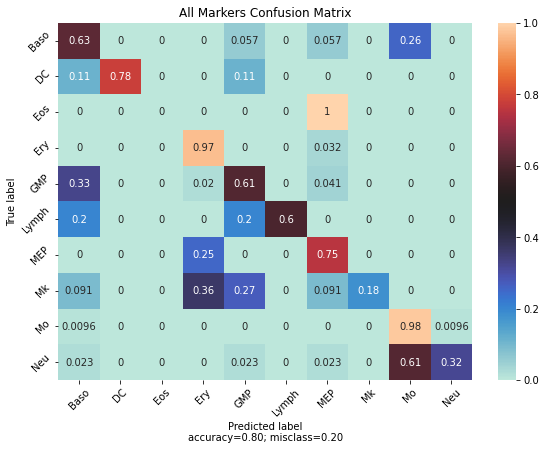

In [30]:
results =  np.load(model_save_path + 'all_markers_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'All Markers Confusion Matrix', save_path = viz_save_path + 'all_markers_cm.pdf', cmap = 'icefire')

### Smash RF

In [31]:
results =  np.load(model_save_path + 'smash_rf_results_{}.npy'.format(1), allow_pickle = True)

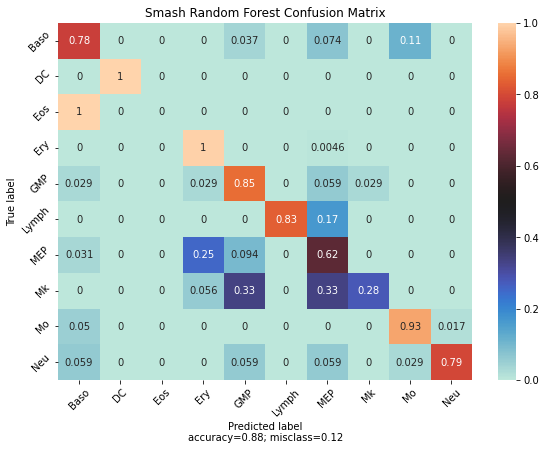

In [32]:
plot_confusion_matrix(results[2], encoder.classes_, title = 'Smash Random Forest Confusion Matrix', save_path = viz_save_path + 'smash_rf_cm.pdf', cmap='icefire')

### Smash DNN

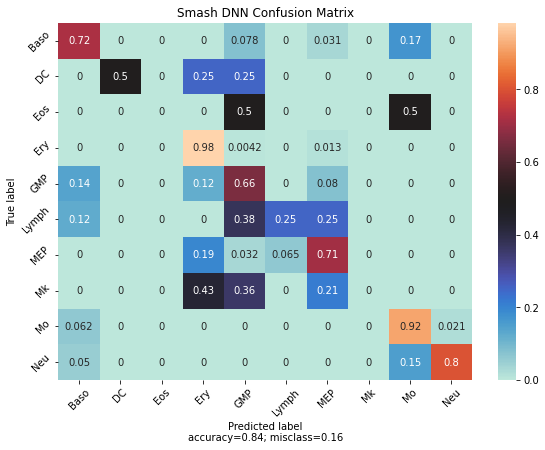

In [33]:
results =  np.load(model_save_path + 'smash_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Smash DNN Confusion Matrix', save_path = viz_save_path + 'smash_cm.pdf', cmap = 'icefire')

### RankCorr

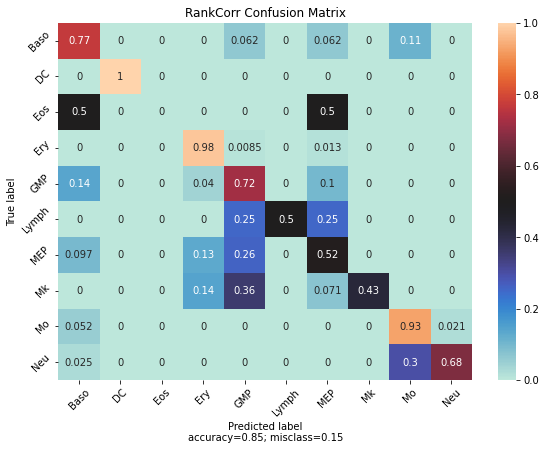

In [34]:
results =  np.load(model_save_path + 'rankcorr_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'RankCorr Confusion Matrix', save_path = viz_save_path + 'rankcorr_cm.pdf', cmap='icefire')

### L1 VAE

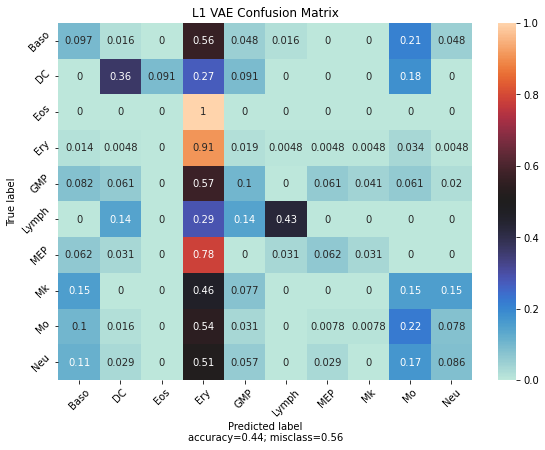

In [35]:
results =  np.load(model_save_path + 'l1_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'L1 VAE Confusion Matrix', save_path = viz_save_path + 'l1_vae_cm.pdf', cmap='icefire')

### Global Gate VAE

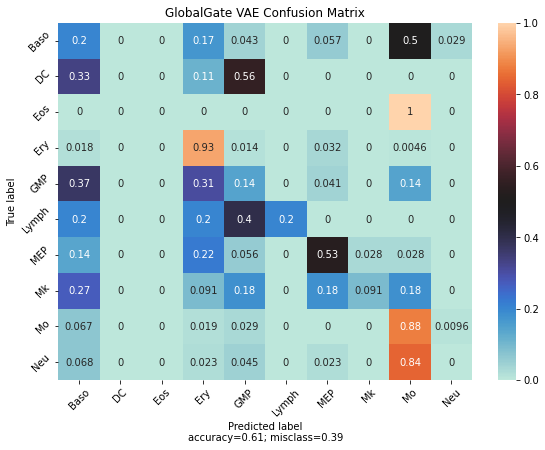

In [36]:
results =  np.load(model_save_path + 'globalgate_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'GlobalGate VAE Confusion Matrix', save_path = viz_save_path + 'globalgate_vae_cm.pdf', cmap='icefire')

### MarkerMap Unsupervised

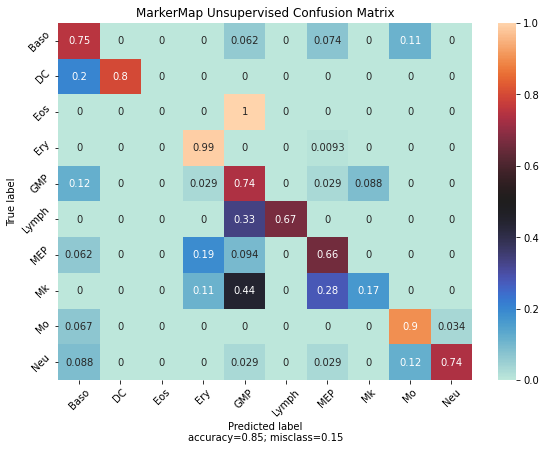

In [37]:
results =  np.load(model_save_path + 'marker_map_unsupervised_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'MarkerMap Unsupervised Confusion Matrix', save_path = viz_save_path + 'marker_map_unsupervised_cm.pdf', cmap = 'icefire')

### MarkerMap Supervised


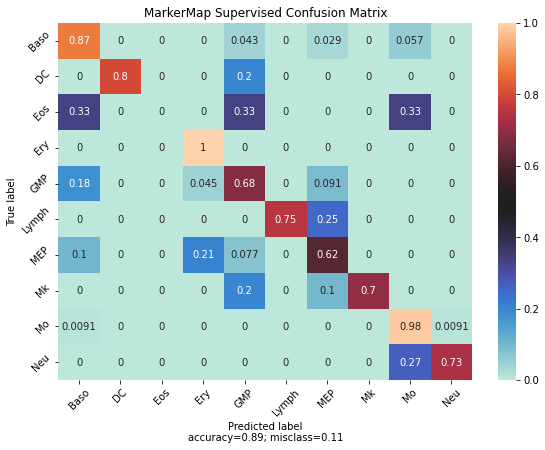

In [38]:
results =  np.load(model_save_path + 'marker_map_supervised_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'MarkerMap Supervised Confusion Matrix', save_path = viz_save_path + 'marker_map_supervised_cm.pdf', cmap = 'icefire')

### MarkerMap Mixed Supervision

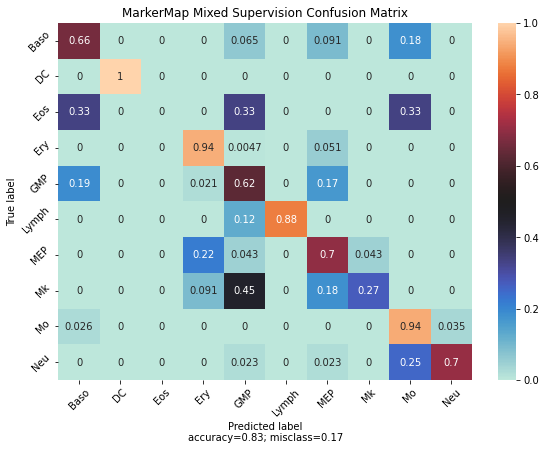

In [39]:
results =  np.load(model_save_path + 'marker_map_mixed_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'MarkerMap Mixed Supervision Confusion Matrix', save_path = viz_save_path + 'marker_map_mixed_cm.pdf', cmap = 'icefire')

### Concrete VAE

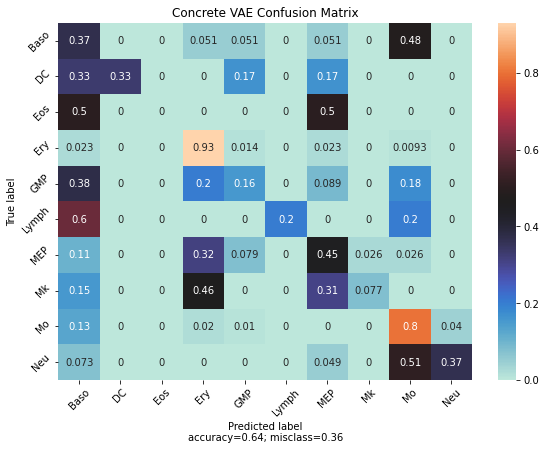

In [40]:
results =  np.load(model_save_path + 'concrete_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Concrete VAE Confusion Matrix', save_path = viz_save_path + 'concrete_vae_cm.pdf', cmap='icefire')

## LassoNet

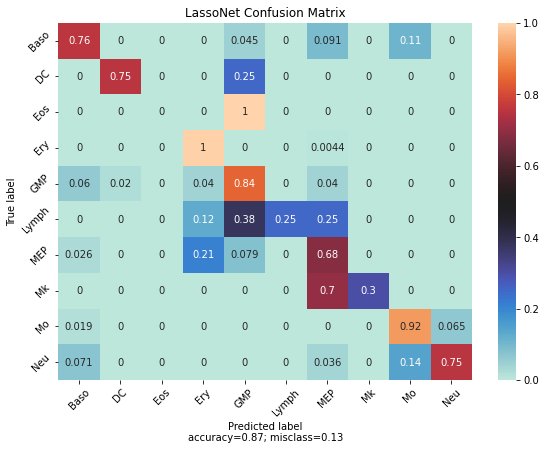

In [41]:
results =  np.load(model_save_path + 'lasso_net_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'LassoNet Confusion Matrix', save_path = viz_save_path + 'lasso_net_cm.pdf', cmap = 'icefire')